# Proyecto práctico - Acrobot


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1:
*   Alumno 2:
*   Alumno 3:
*   Alumno 4:






---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.


---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```


---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [2]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount=r''
drive_root = mount + r"C:\Users\david\OneDrive - Greens Power Products S.L\Documents\RL\proyecto"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [3]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

Archivos en el directorio: 
['.ipynb_checkpoints', 'Proyecto_Opcion_2.ipynb', 'Proyecto_Opcion_2_pruebas.ipynb', 'pruebas', 'Untitled.ipynb']


---
### 1.4. Instalar librerías necesarias

if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.8
  %pip install protobuf==3.20.*
else:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.
  %pip install optuna

---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será [Acrobot-v1](https://www.gymlibrary.dev/environments/classic_control/acrobot/) y el algoritmo que usaremos será _DQN_.
- Se proporciona una solución base ("BASELINE"), que servirá como punto de partida para los experimentos.

Este proyecto práctico consta de tres partes:

1.   Mejorar la solución base basada en e-greedy DQN: hyper-parametros, arquitectura, etc.
2.   Investigar y detallar (a nivel teórico) las diferencias de este agente con: **Bolzman Policy**, **Double DQN**, **Dueling DQN**.
3.   Comparar, empleando keras-rl, el rendimiento (recomensa total, velocidad de convergencia, etc.) con estos métodos más avanzados.
4.   Justificar los hyper-parámetros empleados para cada configuración. Como afecta a la performance, por ejemplo, ¿un cámbio en el scheduler de épsilon? ¿Cómo afecta aumentar/disminuír la actualización de la target network?¿Cómo afecta aumentar/disminuír el tamaño de la memoria?
5. Conclusiones y discusion.

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada.

IMPORTANTE:

* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [38]:
# Imports generales
from __future__ import division
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Imports de entorno
import gym

# Imports de deep learning
import tensorflow as tf

# Imports de keras-rl
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger # Para poder comparar curvas de aprendizaje

from tensorflow.keras.callbacks import Callback

#### Configuración entorno

In [5]:
# Configuración enviroment
env_name = 'Acrobot-v1'
env = gym.make(env_name)

# Semillas de reproducibilidad
np.random.seed(123)
env.seed(123)

# Set observations and actions spaces
n_obs = env.observation_space
nb_actions = env.action_space.n

---
### BASELINE PROPUESTO

Antes de empezar vamos a definir un callback que nos permita guardar los mejores pesos

In [8]:
# Para guardar el mejor modelo
class BestModelSaver(Callback):
    def __init__(self, filepath, monitor='episode_reward', mode='max'):
        self.filepath = filepath
        self.monitor = monitor
        self.best = -np.inf if mode == 'max' else np.inf
        self.mode = mode

    def on_episode_end(self, episode, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            return

        if (self.mode == 'max' and current > self.best) or (self.mode == 'min' and current < self.best):
            print(f"\nEpisode {episode}: {self.monitor} improved from {self.best:.4f} to {current:.4f}. Saving weights.")
            self.best = current
            self.model.save_weights(self.filepath, overwrite=True)        

In [9]:
# Hyper-params
memory_limit = 10000
window_length = 4
max_eps, min_eps, test_eps = 1.0, 0.1, 0.05
steps_exploration = 25000
steps_warmup = 100
gamma = 0.99
target_model_update = 1000
train_interval = 4
learning_rate = 1e-3
nb_steps = 50000
batch_size = 128

# Modelo simple
input_shape = (n_obs)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(nb_actions))
model.add(tf.keras.layers.Activation('linear'))
print(model.summary())

# Memory
memory = SequentialMemory(limit=memory_limit, window_length=window_length)

# Policy
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=max_eps, value_min=min_eps,
                              value_test=test_eps, nb_steps=steps_exploration)
# Agente
egreed_dqn = DQNAgent(model=model, nb_actions=nb_actions,
               policy=policy, memory=memory,
               nb_steps_warmup=steps_warmup, gamma=gamma,
               target_model_update=target_model_update,
               train_interval=train_interval, batch_size=batch_size)

# Compilar
egreed_dqn.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])

# Callbacks
model_name = 'baseline_'
# Guardar los mejores pesos
best_filename = f'best_{model_name}{env_name}_weights.h5f'
best_model_saver = BestModelSaver(
    filepath=best_filename,
    monitor='episode_reward',
    mode='max' 
)
# Guardar el log
log_filename = f'{model_name}{env_name}_log.json'
callbacks = [FileLogger(log_filename, interval=100), best_model_saver]

# Entrenar
egreed_dqn.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Salvar pesos finales
egreed_dqn.save_weights( f'final_{model_name}{env_name}_weights.h5f', overwrite=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 16)                400       
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 activation_2 (Activation)   (None, 16)                0

C:\Users\david\anaconda3\envs\miar_rl\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\david\anaconda3\envs\miar_rl\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')



Episode 0: episode_reward improved from -inf to -500.0000. Saving weights.
   500/50000: episode: 1, duration: 5.674s, episode steps: 500, steps per second:  88, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.012 [0.000, 2.000],  loss: 0.069929, mae: 0.405227, mean_q: -0.259995, mean_eps: 0.989200
  1000/50000: episode: 2, duration: 4.524s, episode steps: 500, steps per second: 111, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.990 [0.000, 2.000],  loss: 0.011715, mae: 0.445532, mean_q: -0.546992, mean_eps: 0.973072
  1500/50000: episode: 3, duration: 3.679s, episode steps: 500, steps per second: 136, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.076 [0.000, 2.000],  loss: 0.034982, mae: 1.051247, mean_q: -1.428106, mean_eps: 0.955072
  2000/50000: episode: 4, duration: 4.151s, episode steps: 500, steps per second: 120, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean 

In [81]:
# Testear los mejores pesos
egreed_dqn.load_weights(f"best_baseline_{env_name}_weights.h5f")
egreed_dqn.test(env, nb_episodes=10, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: -126.000, steps: 127
Episode 2: reward: -130.000, steps: 131
Episode 3: reward: -166.000, steps: 167
Episode 4: reward: -130.000, steps: 131
Episode 5: reward: -140.000, steps: 141
Episode 6: reward: -147.000, steps: 148
Episode 7: reward: -120.000, steps: 121
Episode 8: reward: -133.000, steps: 134
Episode 9: reward: -135.000, steps: 136
Episode 10: reward: -139.000, steps: 140


In [17]:
# Añadimos una función para visualizar datos del log
def visualizar_log(log_filename):
    # Cargar métricas del archivo JSON
    with open(log_filename, 'r') as file:
        log_data = json.load(file)
    
    loss = log_data['loss']
    mae = log_data['mae']
    episode_reward = log_data['episode_reward']
    steps = log_data['nb_steps']
    episode_steps = log_data['nb_episode_steps']
    episodes = log_data['episode']
    reward=log_data['episode_reward']
    df = pd.DataFrame({
        'episode': episodes,
        'reward': reward
    })
    
    df['reward_moving_avg'] = df['reward'].rolling(10).mean()
    
    # Crear una figura con subgráficas 4x2 (4 filas, 2 columnas)
    fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # Tamaño ajustado para mejor distribución
    
    # Gráfica 1: Loss over Steps
    axs[0, 0].plot(steps, loss)
    axs[0, 0].set_title('Loss over Steps')
    axs[0, 0].set_xlabel('Steps')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].grid()
    
    # Gráfica 2: Mae over Steps
    axs[0, 1].plot(steps, mae)
    axs[0, 1].set_title('MAE over Steps')
    axs[0, 1].set_xlabel('Steps')
    axs[0, 1].set_ylabel('MAE')
    axs[0, 1].grid()
    
    # Gráfica 3: Steps per Episode
    axs[1, 0].plot(episodes, episode_steps)
    axs[1, 0].set_title('Steps per Episode')
    axs[1, 0].set_xlabel('Episodes')
    axs[1, 0].set_ylabel('Steps')
    axs[1, 0].grid()
    
    # Gráfica 4: Rewards with Moving Average
    axs[1, 1].plot(df['episode'], df['reward'], label='Reward')
    axs[1, 1].plot(df['episode'], df['reward_moving_avg'], label='Moving Avg', linestyle='--')
    axs[1, 1].set_title('Rewards with Moving Average')
    axs[1, 1].set_xlabel('Episodes')
    axs[1, 1].set_ylabel('Rewards')
    axs[1, 1].legend()
    axs[1, 1].grid()
    
    # Información de métricas agregadas
    text_info = f"Average reward: {df['reward'].mean():.2f}\nMax reward: {df['reward'].max():.2f}\nMin reward: {df['reward'].min():.2f}"
    axs[2, 0].axis('off')  # Desactivar el marco de la subgráfica
    axs[2, 0].text(0.1, 0.5, text_info, fontsize=12, verticalalignment='center')
    
    # Desactivar las subgráficas vacías
    axs[2, 1].axis('off')  # Otra gráfica vacía
    axs[3, 0].axis('off')
    axs[3, 1].axis('off')
    
    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

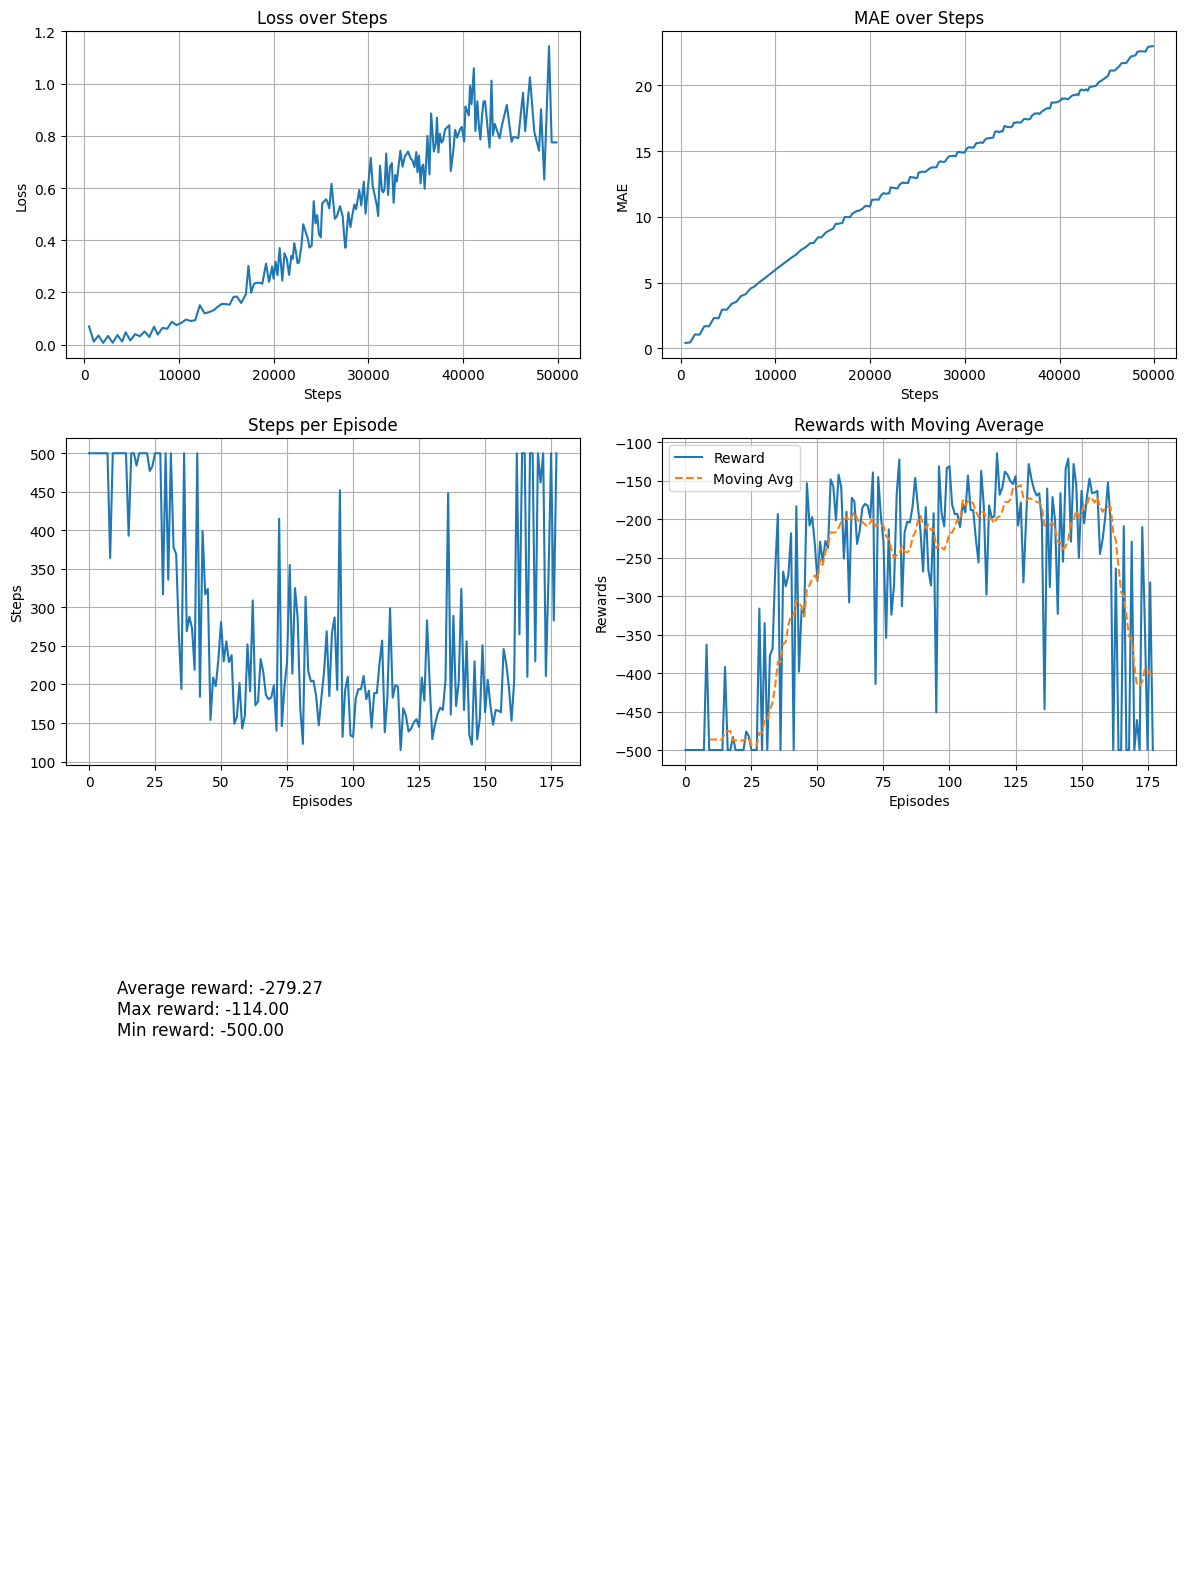

In [18]:
visualizar_log(log_filename)

---
### 1. Mejorar la solución base

Usaremos el módulo Optuna para hacer una serie de entrenamientos de una tacada y evaluar después los resultados, correclacionando cada uno de los parámetros que se han usado en Optuma con la recompensa obtenida. Limitamos el número de steps a 12500 para que acabe en un tiempo prudencial

In [28]:
import optuna
import time

class TimingCallback:
    def __init__(self, total_trials):
        self.start_time = None
        self.times = []
        self.total_trials = total_trials

    def __call__(self, study, trial):
        if self.start_time is None:
            self.start_time = time.time()

        # Calcular tiempo por ensayo
        elapsed_time = time.time() - self.start_time
        self.times.append(elapsed_time / len(self.times) if self.times else elapsed_time)
        estimated_remaining_time = (self.total_trials - len(study.trials)) * self.times[-1]
        
        print(f"Trial {len(study.trials)}/{self.total_trials} complete.")
        print(f"Time per trial: {self.times[-1]:.2f}s | Estimated time remaining: {estimated_remaining_time:.2f}s")

In [33]:
def objective(trial):

    nb_episodes = 5
    n_trials = 50
    
    memory_limit = 10000
    window_length = 4
    test_eps = 0.05
    steps_warmup = 100
    train_interval = 4
    nb_steps = 12500
    
    # Sugerir valores de hiperparámetros
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    gamma = trial.suggest_float('gamma', 0.9, 0.99)
    max_eps = trial.suggest_float('max_eps', 0.8, 1.0)  # Epsilon inicial
    min_eps = trial.suggest_float('min_eps', 0.01, 0.1)  # Epsilon final
    steps_exploration = trial.suggest_int('steps_exploration', 10000, 50000)
    target_model_update = trial.suggest_int('target_model_update', 500, 2000)    
    filters_layer1 = trial.suggest_categorical('filters_layer1', [16, 32, 64])
    filters_layer2 = trial.suggest_categorical('filters_layer2', [16, 32, 64])
    filters_layer3 = trial.suggest_categorical('filters_layer3', [16, 32, 64])

    # Crear modelo
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape),
        tf.keras.layers.Dense(filters_layer1, activation='relu'),
        tf.keras.layers.Dense(filters_layer2, activation='relu'),
        tf.keras.layers.Dense(filters_layer3, activation='relu'),
        tf.keras.layers.Dense(nb_actions, activation='linear'),
    ])
    
    # Crear memoria y política
    memory = SequentialMemory(limit=memory_limit, window_length=window_length)
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),
        attr='eps', value_max=max_eps, value_min=min_eps,
        value_test=test_eps, nb_steps=steps_exploration
    )
    
    # Crear agente
    dqn = DQNAgent(
        model=model,
        nb_actions=nb_actions,
        memory=memory,
        policy=policy,
        gamma=gamma,
        train_interval=train_interval,
        batch_size=batch_size,
    )
    
    dqn.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])
    
    # Entrenar y evaluar
    dqn.fit(env, nb_steps=nb_steps, visualize=False, verbose=0)
    rewards  = dqn.test(env, nb_episodes=nb_episodes, visualize=False)
    mean_reward = sum(rewards.history['episode_reward']) / len(rewards.history['episode_reward'])
    
    return mean_reward

# Crear estudio de Optuna
study = optuna.create_study(direction='maximize')

[I 2024-12-08 12:52:26,977] A new study created in memory with name: no-name-1b1d74be-bc07-49c5-9b4f-6acd61e71faf


In [ ]:
# Callback para estimar tiempo
timing_callback = TimingCallback(total_trials=50)
study.optimize(objective, n_trials=50, callbacks=[timing_callback])

In [71]:
print(f"Mejores hiperparámetros: {study.best_params}")
print(f"Mejor recompensa: {study.best_value}")

Mejores hiperparámetros: {'learning_rate': 0.008051418956069525, 'batch_size': 32, 'gamma': 0.9853246522040829, 'max_eps': 0.8962194534889183, 'min_eps': 0.09663233853405731, 'steps_exploration': 24569, 'target_model_update': 1999, 'filters_layer1': 64, 'filters_layer2': 64, 'filters_layer3': 64}
Mejor recompensa: -77.8


In [58]:
# Convertir ensayos a DataFrame
df = study.trials_dataframe()
df['filters_combined'] = df.apply(
    lambda row: row['params_filters_layer1']*row['params_filters_layer2']*row['params_filters_layer3'], 
    axis=1
)

# Guardar el DataFrame en un archivo CSV
csv_file = "study_trials.csv"
df.to_csv(csv_file, index=False)

print(f"Datos guardados en {csv_file}")

Datos guardados en study_trials.csv


In [59]:
# Filtrar solo columnas numéricas y eliminar -500
df = df[df["value"] != -500]
numeric_df = df.select_dtypes(include=[float, int])

Correlaciones con la recompensa:
number                       -0.045296
params_batch_size             0.034649
params_filters_layer1        -0.036186
params_filters_layer2         0.333344
params_filters_layer3         0.177184
params_gamma                  0.098711
params_learning_rate          0.088253
params_max_eps               -0.001071
params_min_eps               -0.079228
params_steps_exploration     -0.090012
params_target_model_update    0.002748
filters_combined              0.168617
Name: value, dtype: float64


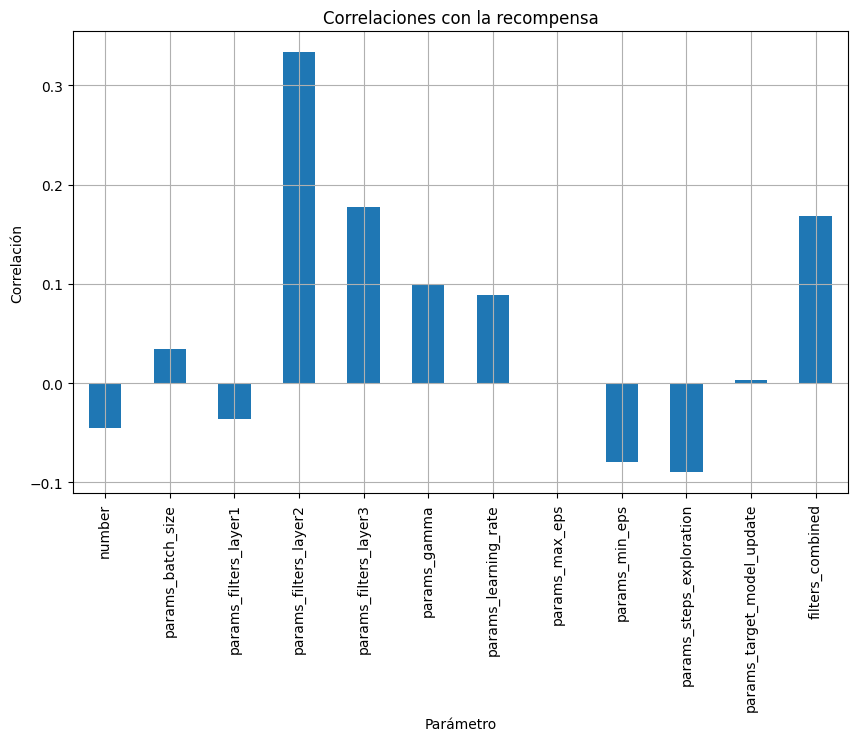

In [70]:
# Calcular la correlación entre las columnas numéricas
correlations = numeric_df.corr()["value"].drop("value")
print("Correlaciones con la recompensa:")
print(correlations)

# Gráfico de barras para visualizar correlaciones
correlations.plot(kind="bar", figsize=(10, 6), title="Correlaciones con la recompensa")
plt.xlabel("Parámetro")
plt.ylabel("Correlación")
plt.grid(True)
plt.show()


Se puede apreciar que los valores que más afectan a la recompensan son los filtros de la capa 2 y 3 (siendo más elevantes los de la capa 2), mientras que los de la capa 1 aparecen con correlación negativa, indicando que contra más bajos mejor. Esto nos lleva a eliminar la capa 1, e incrementar los filtros de la capa 2 (que pasará a ser la 1).

Aunque no se ha evaluado, es conocido que la memoria nunca está de más, por lo que la incrementamos considerablemente. Del mismo modo incrementaremos el steps_warmup para eliminar el warning.

Reduciremos el parámetro steps_exploration a la mitad, y dejaremos todo lo demás igual ya que no parecen tan significativos.

In [68]:
# Hyper-params anteriores
# memory_limit = 10000
# window_length = 4
# max_eps, min_eps, test_eps = 1.0, 0.1, 0.05
# steps_exploration = 25000
# steps_warmup = 100
# gamma = 0.99
# target_model_update = 1000
# train_interval = 4
# learning_rate = 1e-3
# nb_steps = 50000
# batch_size = 128

# Hyper-params
memory_limit = 1000000
window_length = 4
max_eps, min_eps, test_eps = 1.0, 0.1, 0.05
steps_exploration = 12500
steps_warmup = 500
gamma = 0.99
target_model_update = 1000
train_interval = 4
learning_rate = 1e-3
nb_steps = 50000
batch_size = 128

# Modelo simple
input_shape = (n_obs)
best_params_model = tf.keras.models.Sequential()
best_params_model.add(tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape))
#best_params_model.add(tf.keras.layers.Dense(16))
#best_params_model.add(tf.keras.layers.Activation('relu'))
best_params_model.add(tf.keras.layers.Dense(128))
best_params_model.add(tf.keras.layers.Activation('relu'))
best_params_model.add(tf.keras.layers.Dense(64))
best_params_model.add(tf.keras.layers.Activation('relu'))
best_params_model.add(tf.keras.layers.Dense(nb_actions))
best_params_model.add(tf.keras.layers.Activation('linear'))
print(best_params_model.summary())

# Memory
memory = SequentialMemory(limit=memory_limit, window_length=window_length)

# Policy
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=max_eps, value_min=min_eps,
                              value_test=test_eps, nb_steps=steps_exploration)
# Agente
best_params_egreed_dqn = DQNAgent(model=best_params_model, nb_actions=nb_actions,
               policy=policy, memory=memory,
               nb_steps_warmup=steps_warmup, gamma=gamma,
               target_model_update=target_model_update,
               train_interval=train_interval, batch_size=batch_size)

# Compilar
best_params_egreed_dqn.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])

# Callbacks
model_name = 'best_params_'
# Guardar los mejores pesos
best_filename = f'best_{model_name}{env_name}_weights.h5f'
best_model_saver = BestModelSaver(
    filepath=best_filename,
    monitor='episode_reward',
    mode='max' 
)
# Guardar el log
log_filename = f'{model_name}{env_name}_log.json'
callbacks = [FileLogger(log_filename, interval=100), best_model_saver]

# Entrenar
best_params_egreed_dqn.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Salvar pesos finales
best_params_egreed_dqn.save_weights( f'final_{model_name}{env_name}_weights.h5f', overwrite=True)

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_77 (Flatten)        (None, 24)                0         
                                                                 
 dense_308 (Dense)           (None, 128)               3200      
                                                                 
 activation_44 (Activation)  (None, 128)               0         
                                                                 
 dense_309 (Dense)           (None, 64)                8256      
                                                                 
 activation_45 (Activation)  (None, 64)                0         
                                                                 
 dense_310 (Dense)           (None, 3)                 195       
                                                                 
 activation_46 (Activation)  (None, 3)               

C:\Users\david\anaconda3\envs\miar_rl\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Episode 0: episode_reward improved from -inf to -500.0000. Saving weights.
   500/50000: episode: 1, duration: 9.529s, episode steps: 500, steps per second:  52, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.066 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


C:\Users\david\anaconda3\envs\miar_rl\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1000/50000: episode: 2, duration: 25.793s, episode steps: 500, steps per second:  19, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.038 [0.000, 2.000],  loss: 0.018256, mae: 0.301517, mean_q: -0.239799, mean_eps: 0.946000
  1500/50000: episode: 3, duration: 10.394s, episode steps: 500, steps per second:  48, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.996 [0.000, 2.000],  loss: 0.025912, mae: 0.945415, mean_q: -1.290487, mean_eps: 0.910144
  2000/50000: episode: 4, duration: 9.124s, episode steps: 500, steps per second:  55, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.944 [0.000, 2.000],  loss: 0.002325, mae: 0.908711, mean_q: -1.292239, mean_eps: 0.874144
  2500/50000: episode: 5, duration: 9.374s, episode steps: 500, steps per second:  53, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.914 [0.000, 2.000],  loss: 0.028605, mae: 1.605585, mean_q: -2.2

In [83]:
# Testear los mejores pesos
best_params_egreed_dqn.load_weights(f"final_{model_name}{env_name}_weights.h5f")
best_params_egreed_dqn.test(env, nb_episodes=20, visualize=False)

Testing for 20 episodes ...
Episode 1: reward: -96.000, steps: 97
Episode 2: reward: -74.000, steps: 75
Episode 3: reward: -89.000, steps: 90
Episode 4: reward: -79.000, steps: 80
Episode 5: reward: -72.000, steps: 73
Episode 6: reward: -77.000, steps: 78
Episode 7: reward: -78.000, steps: 79
Episode 8: reward: -72.000, steps: 73
Episode 9: reward: -90.000, steps: 91
Episode 10: reward: -99.000, steps: 100
Episode 11: reward: -81.000, steps: 82
Episode 12: reward: -92.000, steps: 93
Episode 13: reward: -101.000, steps: 102
Episode 14: reward: -104.000, steps: 105
Episode 15: reward: -96.000, steps: 97
Episode 16: reward: -113.000, steps: 114
Episode 17: reward: -82.000, steps: 83
Episode 18: reward: -89.000, steps: 90
Episode 19: reward: -108.000, steps: 109
Episode 20: reward: -82.000, steps: 83


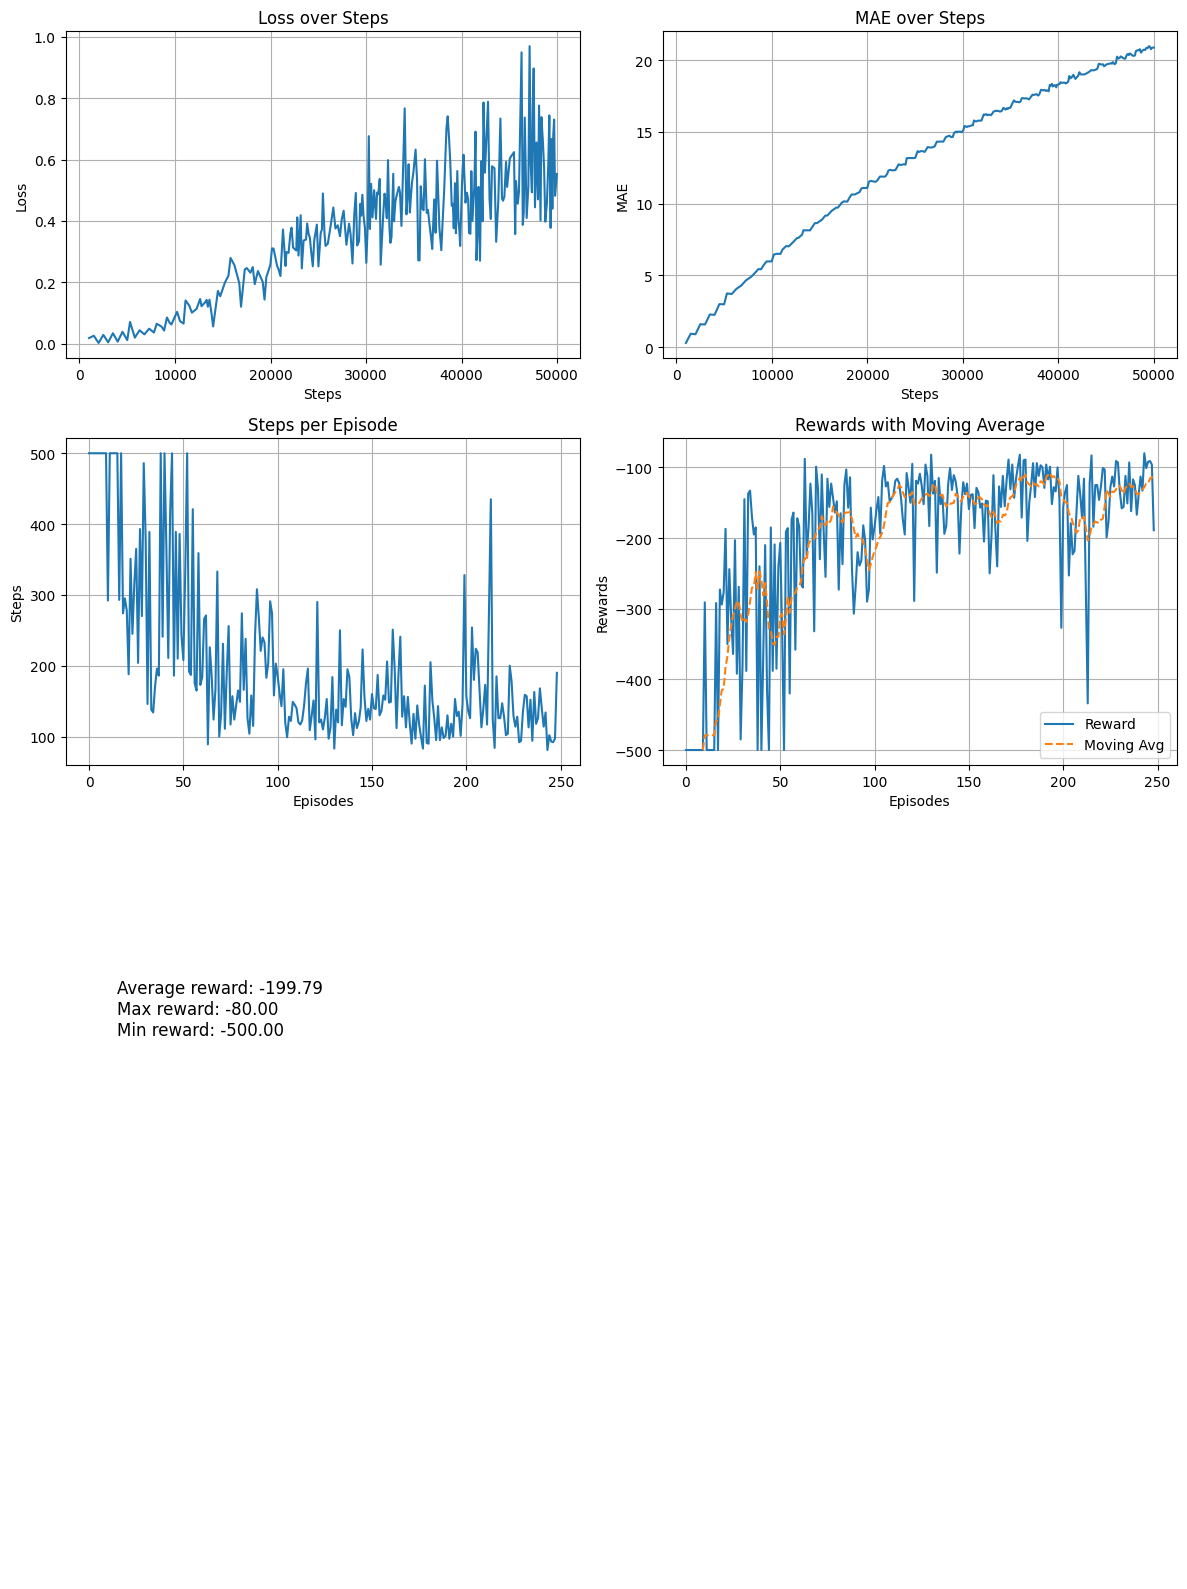

In [69]:
visualizar_log(log_filename)

Quizás se le podrían dar más steps para ver si seguía mejorando, pero los valores que han salido en test son suficientemente buenos, y mejores que el modelo baseline.

---
### 2. Investigar y presentar las diferencias de este agente con versiones más avanzadas.

#### 1. e-greedy DQN

Como hemos visto en clase, en el algoritmo Deep Q-Network (DQN) empleamos redes neuronales profundas para aproximar la función de valor Q, que representa la calidad de una acción en un estado determinado. Además, en DQN se utiliza la política ε-greedy para equilibrar la exploración y la explotación:

- Exploración: Con una probabilidad de ε, el agente elige una acción aleatoria, lo que permite explorar nuevas posibilidades.
- Explotación: Con una probabilidad de 1−ε, el agente selecciona la acción que maximiza la función de valor Q, es decir, aquella que parece ser la mejor en ese momento.

Sin embargo, este enfoque presenta una limitación importante en el proceso de exploración. Ya que la naturaleza aleatoria de la política puede hacer que el agente quede atrapado en políticas subóptimas, pues las decisiones de exploración no dependen de las diferencias en los valores de las acciones. Esta aleatoriedad puede reducir la efectividad del aprendizaje en entornos más complejos

#### 2. Boltzmann Policy

La Política Boltzmann es una mejora respecto a la política ε-greedy, ya que reemplaza la elección aleatoria de acciones por una distribución probabilística basada en la temperatura T. La probabilidad de seleccionar una acción a en un estado s se calcula usando la siguiente fórmula:

P(a|s) = exp(Q(s,a) / T) / sum(exp(Q(s,a') / T))

Donde:
- Q(s, a) es el valor Q de la acción a en el estado s.
- T es un parámetro que regula el equilibrio entre exploración y explotación.

Dependiendo del valor de T:
- Temperatura alta (T > 1): Aumentamos la exploración, ya que las probabilidades de seleccionar acciones menos valoradas (acciones subóptimas) se incrementan.
- Temperatura baja (T < 1): Fomentamos la explotación, ya que las probabilidades de seleccionar las mejores acciones, aquellas con mayor valor Q, aumentan.

La principal ventaja de la Política Boltzmann es que ofrece una exploración más gradual en comparación con ε-greedy, adaptándose dinámicamente a las diferencias en los valores Q y ajustando el comportamiento del agente según el contexto.

#### 3. Double DQN

En la versión de Double DQN, que es una extensión del algoritmo DQN, buscamos solucionar un problema crítico del DQN clásico: la sobreestimación de los valores Q. En DQN tradicional, durante la actualización de la red neuronal, se utiliza la misma red tanto para seleccionar la acción (maximizando Q(s,a)) como para evaluar la acción seleccionada. Este enfoque puede generar una sobreestimación sistemática de los valores Q, ya que la red sobrevalora las acciones optimistas que ella misma selecciona.

La mejora clave de Double DQN es el uso de dos redes neuronales:
- Q-red (la red principal) se encarga de seleccionar la acción.
- Q-target (la red de objetivo) se utiliza para evaluar la acción seleccionada.

El proceso de actualización lo realizamos de la siguiente manera:

L(θ) = E[(r + γ * Q_target(s', argmax_a' Q(s', a'; θ^-); θ) - Q(s, a; θ))^2]

Este enfoque reduce el sesgo en la actualización y mejora la estabilidad del aprendizaje al evitar la sobreestimación de los valores de las acciones.

#### 4. Dueling DQN

El Dueling DQN se introduce una mejora significativa en la arquitectura de DQN al dividir la red neuronal en dos componentes distintos:
1. Valor del estado V(s): Estima la calidad de estar en un estado determinado, independientemente de la acción tomada.
2. Ventaja de la acción A(s, a): Estima la diferencia entre la acción seleccionada y el valor promedio de las acciones en el estado s.

La función de valor Q se calcula como la combinación de ambos componentes:

Q(s, a) = V(s) + A(s, a) - 1 / |A|

Este enfoque nos permite que el agente aprenda primero sobre el valor global de estar en un estado dado, antes de centrarse en las diferencias de valor entre las distintas acciones. La principal ventaja de este enfoque es que mejora la eficiencia del aprendizaje, especialmente en situaciones donde la diferencia entre las acciones no es significativa y donde muchas acciones tienen valores similares en un estado determinado. Esto hace que el agente se enfoque en los estados importantes, acelerando el proceso de aprendizaje.


---
### 3. Comparar, empleando keras-rl, el rendimiento de estos métodos más avanzados.

#### Double DQN

Para garantizar una comparación justa entre el agente Double DQN y el agente greedy, utilizaremos una red neuronal con la misma arquitectura en ambos casos. Esta red contará con tres capas densas (fully connected) de tamaños 128, 64 y un número de neuronas igual al número de acciones posibles del entorno (numero_acciones) en la última capa.

Como se explicó en el apartado anterior, Double DQN se basa en el uso de dos redes neuronales:

- Una red principal (Q-network): que seleccionará la acción a ejecutar.
- Una red objetivo (Q-target network): que evaluará la acción seleccionada, ayudando a reducir el problema de sobreestimación que ocurre en DQN.

En Keras-RL, podemos habilitar esta funcionalidad utilizando el atributo enable_double_dqn=True. Esta configuración asegura que el agente implemente automáticamente la lógica necesaria para entrenar y utilizar ambas redes. La red objetivo se actualiza cada cierto número de pasos (controlado por el parámetro target_model_update), copiando los pesos de la red principal en intervalos regulares.

Antes de proceder a la comparación, realizaremos una búsqueda de los mejores hiperparámetros para el agente Double DQN. Esto incluirá parámetros como:

In [6]:
def objective(trial):

    nb_episodes = 5
    n_trials = 25
    
    memory_limit = 100000
    window_length = 4
    test_eps = 0.05
    steps_warmup = 100
    train_interval = 4
    nb_steps = 18000
    
    # Sugerir valores de hiperparámetros
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [64, 128])
    gamma = trial.suggest_float('gamma', 0.9, 0.99)
    max_eps = trial.suggest_float('max_eps', 0.8, 1.0)  
    min_eps = trial.suggest_float('min_eps', 0.01, 0.1)  
    steps_exploration = trial.suggest_int('steps_exploration', 5000, 30000)
    target_model_update = trial.suggest_int('target_model_update', 500, 1000)    
    filters_layer1 = trial.suggest_categorical('filters_layer1', [32, 64, 128])
    filters_layer2 = trial.suggest_categorical('filters_layer2', [16, 32, 64])

    # Crear modelo
    double_dqn_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape),
        tf.keras.layers.Dense(filters_layer1, activation='relu'),
        tf.keras.layers.Dense(filters_layer2, activation='relu'),
        tf.keras.layers.Dense(nb_actions, activation='linear'),
    ])
    
    # Crear memoria y política
    memory = SequentialMemory(limit=memory_limit, window_length=window_length)
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),
        attr='eps', value_max=max_eps, value_min=min_eps,
        value_test=test_eps, nb_steps=steps_exploration
    )
    
    # Agente Double DQN
    double_dqn_agent = DQNAgent(model=double_dqn_model, nb_actions=nb_actions,
                            policy=policy, memory=memory,
                            nb_steps_warmup=steps_warmup, gamma=gamma,
                            target_model_update=target_model_update,
                            train_interval=train_interval, batch_size=batch_size,
                            enable_double_dqn=True)
    
    double_dqn_agent.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])
    
    # Entrenar y evaluar
    double_dqn_agent.fit(env, nb_steps=nb_steps, visualize=False, verbose=0)
    rewards  = double_dqn_agent.test(env, nb_episodes=nb_episodes, visualize=False)
    mean_reward = sum(rewards.history['episode_reward']) / len(rewards.history['episode_reward'])
    
    return mean_reward

# Crear estudio de Optuna
study = optuna.create_study(direction='maximize')



[I 2024-12-14 21:26:29,446] A new study created in memory with name: no-name-4292e0ed-d850-4960-8797-d3fba5b055bd


In [7]:
# Callback para estimar tiempo
timing_callback = TimingCallback(total_trials=50)
study.optimize(objective, n_trials=50, callbacks=[timing_callback])

C:\Users\puigm\AppData\Local\Temp\ipykernel_30100\1116890024.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
C:\Users\puigm\anaconda3\envs\miar_rl_sergi\lib\site-packages\tensorflow\python\keras\engine\training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\puigm\anaconda3\envs\miar_rl_sergi\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-u

Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:27:28,840] Trial 0 finished with value: -500.0 and parameters: {'learning_rate': 0.0016549085533591882, 'batch_size': 128, 'gamma': 0.919217434763765, 'max_eps': 0.961346918029509, 'min_eps': 0.09644303522740813, 'steps_exploration': 29969, 'target_model_update': 632, 'filters_layer1': 32, 'filters_layer2': 16}. Best is trial 0 with value: -500.0.


Episode 5: reward: -500.000, steps: 500
Trial 1/50 complete.
Time per trial: 0.00s | Estimated time remaining: 0.00s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:28:22,015] Trial 1 finished with value: -500.0 and parameters: {'learning_rate': 0.0006456318809084555, 'batch_size': 128, 'gamma': 0.9610469187245654, 'max_eps': 0.9086203899577792, 'min_eps': 0.01741268131896898, 'steps_exploration': 28673, 'target_model_update': 867, 'filters_layer1': 64, 'filters_layer2': 16}. Best is trial 0 with value: -500.0.


Episode 5: reward: -500.000, steps: 500
Trial 2/50 complete.
Time per trial: 53.17s | Estimated time remaining: 2552.40s
Testing for 5 episodes ...
Episode 1: reward: -248.000, steps: 249
Episode 2: reward: -193.000, steps: 194
Episode 3: reward: -197.000, steps: 198


[I 2024-12-14 21:29:06,745] Trial 2 finished with value: -267.0 and parameters: {'learning_rate': 0.00020923693241824205, 'batch_size': 64, 'gamma': 0.9360143690952394, 'max_eps': 0.8781246666729243, 'min_eps': 0.06831590407138678, 'steps_exploration': 11975, 'target_model_update': 522, 'filters_layer1': 64, 'filters_layer2': 64}. Best is trial 2 with value: -267.0.


Episode 4: reward: -500.000, steps: 500
Episode 5: reward: -197.000, steps: 198
Trial 3/50 complete.
Time per trial: 48.95s | Estimated time remaining: 2300.77s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:29:53,195] Trial 3 finished with value: -500.0 and parameters: {'learning_rate': 0.00047782304637143723, 'batch_size': 64, 'gamma': 0.9727544694703076, 'max_eps': 0.849975275962859, 'min_eps': 0.04829237674662444, 'steps_exploration': 13736, 'target_model_update': 759, 'filters_layer1': 32, 'filters_layer2': 32}. Best is trial 2 with value: -267.0.


Episode 5: reward: -500.000, steps: 500
Trial 4/50 complete.
Time per trial: 48.12s | Estimated time remaining: 2213.43s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:30:40,935] Trial 4 finished with value: -500.0 and parameters: {'learning_rate': 0.0032118631403876326, 'batch_size': 64, 'gamma': 0.9845485168332182, 'max_eps': 0.8889665017030227, 'min_eps': 0.03858274636774411, 'steps_exploration': 17150, 'target_model_update': 901, 'filters_layer1': 64, 'filters_layer2': 32}. Best is trial 2 with value: -267.0.


Episode 5: reward: -500.000, steps: 500
Trial 5/50 complete.
Time per trial: 48.02s | Estimated time remaining: 2161.05s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -307.000, steps: 308
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:31:38,815] Trial 5 finished with value: -424.8 and parameters: {'learning_rate': 0.0002114625491756244, 'batch_size': 128, 'gamma': 0.9667544259764814, 'max_eps': 0.923893094679946, 'min_eps': 0.03871846269706753, 'steps_exploration': 16119, 'target_model_update': 865, 'filters_layer1': 64, 'filters_layer2': 16}. Best is trial 2 with value: -267.0.


Episode 5: reward: -317.000, steps: 318
Trial 6/50 complete.
Time per trial: 49.99s | Estimated time remaining: 2199.77s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -272.000, steps: 273
Episode 3: reward: -187.000, steps: 188


[I 2024-12-14 21:32:38,780] Trial 6 finished with value: -327.8 and parameters: {'learning_rate': 0.0003486055037251083, 'batch_size': 128, 'gamma': 0.9541942680647912, 'max_eps': 0.8464905930543122, 'min_eps': 0.07277175047007205, 'steps_exploration': 9781, 'target_model_update': 621, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 2 with value: -267.0.


Episode 4: reward: -500.000, steps: 500
Episode 5: reward: -180.000, steps: 181
Trial 7/50 complete.
Time per trial: 51.66s | Estimated time remaining: 2221.24s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:33:39,613] Trial 7 finished with value: -500.0 and parameters: {'learning_rate': 0.0034274400355700364, 'batch_size': 128, 'gamma': 0.98125000942806, 'max_eps': 0.8826649975879862, 'min_eps': 0.022903729931960826, 'steps_exploration': 5348, 'target_model_update': 944, 'filters_layer1': 64, 'filters_layer2': 64}. Best is trial 2 with value: -267.0.


Episode 5: reward: -500.000, steps: 500
Trial 8/50 complete.
Time per trial: 52.97s | Estimated time remaining: 2224.63s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:34:42,217] Trial 8 finished with value: -500.0 and parameters: {'learning_rate': 0.0014319050442014327, 'batch_size': 128, 'gamma': 0.9460578765931541, 'max_eps': 0.8583569735489612, 'min_eps': 0.09160430419387063, 'steps_exploration': 20376, 'target_model_update': 647, 'filters_layer1': 128, 'filters_layer2': 16}. Best is trial 2 with value: -267.0.


Episode 5: reward: -500.000, steps: 500
Trial 9/50 complete.
Time per trial: 54.17s | Estimated time remaining: 2221.05s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:35:36,222] Trial 9 finished with value: -500.0 and parameters: {'learning_rate': 0.0022230055350090715, 'batch_size': 64, 'gamma': 0.9739330771403542, 'max_eps': 0.9865473619002783, 'min_eps': 0.07774994226528224, 'steps_exploration': 7173, 'target_model_update': 851, 'filters_layer1': 64, 'filters_layer2': 16}. Best is trial 2 with value: -267.0.


Episode 5: reward: -500.000, steps: 500
Trial 10/50 complete.
Time per trial: 54.15s | Estimated time remaining: 2166.14s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:36:31,893] Trial 10 finished with value: -500.0 and parameters: {'learning_rate': 0.00010197806201477189, 'batch_size': 64, 'gamma': 0.9229139020811408, 'max_eps': 0.8202075161212751, 'min_eps': 0.06504568467201885, 'steps_exploration': 22480, 'target_model_update': 500, 'filters_layer1': 32, 'filters_layer2': 64}. Best is trial 2 with value: -267.0.


Episode 5: reward: -500.000, steps: 500
Trial 11/50 complete.
Time per trial: 54.31s | Estimated time remaining: 2117.90s
Testing for 5 episodes ...
Episode 1: reward: -195.000, steps: 196
Episode 2: reward: -289.000, steps: 290
Episode 3: reward: -217.000, steps: 218


[I 2024-12-14 21:37:28,424] Trial 11 finished with value: -233.0 and parameters: {'learning_rate': 0.00030152277798790856, 'batch_size': 64, 'gamma': 0.9395443974111748, 'max_eps': 0.8065545289662337, 'min_eps': 0.0695173924893551, 'steps_exploration': 10226, 'target_model_update': 501, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 11 with value: -233.0.


Episode 4: reward: -251.000, steps: 252
Episode 5: reward: -213.000, steps: 214
Trial 12/50 complete.
Time per trial: 54.51s | Estimated time remaining: 2071.29s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:38:27,079] Trial 12 finished with value: -500.0 and parameters: {'learning_rate': 0.00016149049951392808, 'batch_size': 64, 'gamma': 0.932720740867255, 'max_eps': 0.8051191310830784, 'min_eps': 0.06031461198621536, 'steps_exploration': 12181, 'target_model_update': 501, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 11 with value: -233.0.


Episode 5: reward: -500.000, steps: 500
Trial 13/50 complete.
Time per trial: 54.85s | Estimated time remaining: 2029.57s
Testing for 5 episodes ...
Episode 1: reward: -246.000, steps: 247
Episode 2: reward: -323.000, steps: 324
Episode 3: reward: -323.000, steps: 324
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:39:26,855] Trial 13 finished with value: -342.2 and parameters: {'learning_rate': 0.0003040115694352278, 'batch_size': 64, 'gamma': 0.935665774664525, 'max_eps': 0.93512578931638, 'min_eps': 0.08146844647957918, 'steps_exploration': 9991, 'target_model_update': 574, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 11 with value: -233.0.


Episode 5: reward: -319.000, steps: 320
Trial 14/50 complete.
Time per trial: 55.23s | Estimated time remaining: 1988.35s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:40:28,217] Trial 14 finished with value: -500.0 and parameters: {'learning_rate': 0.0007344127259041802, 'batch_size': 64, 'gamma': 0.9074843578017466, 'max_eps': 0.8264175800687402, 'min_eps': 0.05231118683240617, 'steps_exploration': 12579, 'target_model_update': 734, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 11 with value: -233.0.


Episode 5: reward: -500.000, steps: 500
Trial 15/50 complete.
Time per trial: 55.67s | Estimated time remaining: 1948.44s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:41:30,548] Trial 15 finished with value: -500.0 and parameters: {'learning_rate': 0.00010187719259337923, 'batch_size': 64, 'gamma': 0.9429046272625214, 'max_eps': 0.8668617635255716, 'min_eps': 0.06946776971670457, 'steps_exploration': 8458, 'target_model_update': 561, 'filters_layer1': 64, 'filters_layer2': 64}. Best is trial 11 with value: -233.0.


Episode 5: reward: -500.000, steps: 500
Trial 16/50 complete.
Time per trial: 56.11s | Estimated time remaining: 1907.87s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:44:10,675] Trial 16 finished with value: -500.0 and parameters: {'learning_rate': 0.00025859199681159634, 'batch_size': 64, 'gamma': 0.9019617065772734, 'max_eps': 0.8006592924414884, 'min_eps': 0.08548752887862017, 'steps_exploration': 14964, 'target_model_update': 705, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 11 with value: -233.0.


Episode 5: reward: -500.000, steps: 500
Trial 17/50 complete.
Time per trial: 62.61s | Estimated time remaining: 2066.28s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:45:16,325] Trial 17 finished with value: -500.0 and parameters: {'learning_rate': 0.008411288734123093, 'batch_size': 64, 'gamma': 0.923358665054758, 'max_eps': 0.8304603722718803, 'min_eps': 0.04543865730843045, 'steps_exploration': 18625, 'target_model_update': 555, 'filters_layer1': 64, 'filters_layer2': 32}. Best is trial 11 with value: -233.0.


Episode 5: reward: -500.000, steps: 500
Trial 18/50 complete.
Time per trial: 62.79s | Estimated time remaining: 2009.38s
Testing for 5 episodes ...
Episode 1: reward: -301.000, steps: 302
Episode 2: reward: -332.000, steps: 333
Episode 3: reward: -233.000, steps: 234
Episode 4: reward: -220.000, steps: 221


[I 2024-12-14 21:46:22,039] Trial 18 finished with value: -267.8 and parameters: {'learning_rate': 0.00018452236150242238, 'batch_size': 64, 'gamma': 0.9514035175104655, 'max_eps': 0.9558520883795353, 'min_eps': 0.05916111548992107, 'steps_exploration': 23634, 'target_model_update': 804, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 11 with value: -233.0.


Episode 5: reward: -253.000, steps: 254
Trial 19/50 complete.
Time per trial: 62.96s | Estimated time remaining: 1951.62s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -409.000, steps: 410


[I 2024-12-14 21:47:29,181] Trial 19 finished with value: -481.8 and parameters: {'learning_rate': 0.0004732627967371098, 'batch_size': 64, 'gamma': 0.9336660557023948, 'max_eps': 0.8732443864344668, 'min_eps': 0.07284328153786349, 'steps_exploration': 5208, 'target_model_update': 991, 'filters_layer1': 32, 'filters_layer2': 64}. Best is trial 11 with value: -233.0.


Episode 5: reward: -500.000, steps: 500
Trial 20/50 complete.
Time per trial: 63.18s | Estimated time remaining: 1895.27s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:48:38,149] Trial 20 finished with value: -500.0 and parameters: {'learning_rate': 0.0009902869482956754, 'batch_size': 64, 'gamma': 0.9137247783836845, 'max_eps': 0.8998020643349637, 'min_eps': 0.03146182786567125, 'steps_exploration': 10480, 'target_model_update': 668, 'filters_layer1': 128, 'filters_layer2': 32}. Best is trial 11 with value: -233.0.


Episode 5: reward: -500.000, steps: 500
Trial 21/50 complete.
Time per trial: 63.47s | Estimated time remaining: 1840.50s
Testing for 5 episodes ...
Episode 1: reward: -89.000, steps: 90
Episode 2: reward: -106.000, steps: 107
Episode 3: reward: -90.000, steps: 91
Episode 4: reward: -128.000, steps: 129


[I 2024-12-14 21:49:47,140] Trial 21 finished with value: -100.6 and parameters: {'learning_rate': 0.00016459679530714147, 'batch_size': 64, 'gamma': 0.9508572617728388, 'max_eps': 0.9477799850516314, 'min_eps': 0.05977890419767582, 'steps_exploration': 25329, 'target_model_update': 800, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -90.000, steps: 91
Trial 22/50 complete.
Time per trial: 63.73s | Estimated time remaining: 1784.40s
Testing for 5 episodes ...
Episode 1: reward: -197.000, steps: 198
Episode 2: reward: -360.000, steps: 361
Episode 3: reward: -350.000, steps: 351
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:50:58,874] Trial 22 finished with value: -314.6 and parameters: {'learning_rate': 0.0001525658115964386, 'batch_size': 64, 'gamma': 0.9414560155021593, 'max_eps': 0.9933803201974867, 'min_eps': 0.061944510598507606, 'steps_exploration': 25493, 'target_model_update': 790, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -166.000, steps: 167
Trial 23/50 complete.
Time per trial: 64.09s | Estimated time remaining: 1730.49s
Testing for 5 episodes ...
Episode 1: reward: -241.000, steps: 242
Episode 2: reward: -162.000, steps: 163
Episode 3: reward: -261.000, steps: 262
Episode 4: reward: -117.000, steps: 118


[I 2024-12-14 21:52:11,673] Trial 23 finished with value: -187.0 and parameters: {'learning_rate': 0.00040173224849895494, 'batch_size': 64, 'gamma': 0.9558649815549132, 'max_eps': 0.9484041412543263, 'min_eps': 0.053083965550983506, 'steps_exploration': 20044, 'target_model_update': 583, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -154.000, steps: 155
Trial 24/50 complete.
Time per trial: 64.47s | Estimated time remaining: 1676.24s
Testing for 5 episodes ...
Episode 1: reward: -187.000, steps: 188
Episode 2: reward: -181.000, steps: 182
Episode 3: reward: -191.000, steps: 192


[I 2024-12-14 21:53:25,112] Trial 24 finished with value: -174.2 and parameters: {'learning_rate': 0.0004415681256009629, 'batch_size': 64, 'gamma': 0.9584181951252244, 'max_eps': 0.9598905009296976, 'min_eps': 0.054948788209028654, 'steps_exploration': 26477, 'target_model_update': 591, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 4: reward: -140.000, steps: 141
Episode 5: reward: -172.000, steps: 173
Trial 25/50 complete.
Time per trial: 64.84s | Estimated time remaining: 1621.12s
Testing for 5 episodes ...
Episode 1: reward: -114.000, steps: 115
Episode 2: reward: -154.000, steps: 155
Episode 3: reward: -118.000, steps: 119


[I 2024-12-14 21:54:40,389] Trial 25 finished with value: -125.2 and parameters: {'learning_rate': 0.0004508731081343785, 'batch_size': 64, 'gamma': 0.9565779535213323, 'max_eps': 0.963553397187995, 'min_eps': 0.054290544337488617, 'steps_exploration': 26923, 'target_model_update': 696, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 4: reward: -131.000, steps: 132
Episode 5: reward: -109.000, steps: 110
Trial 26/50 complete.
Time per trial: 65.26s | Estimated time remaining: 1566.29s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:55:59,355] Trial 26 finished with value: -500.0 and parameters: {'learning_rate': 0.0007667874335423354, 'batch_size': 64, 'gamma': 0.9625287627869833, 'max_eps': 0.9772933421719494, 'min_eps': 0.04191642178787678, 'steps_exploration': 26818, 'target_model_update': 707, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 27/50 complete.
Time per trial: 65.79s | Estimated time remaining: 1513.15s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:57:19,798] Trial 27 finished with value: -500.0 and parameters: {'learning_rate': 0.0010494039565424737, 'batch_size': 64, 'gamma': 0.9481359302296601, 'max_eps': 0.9329852618330607, 'min_eps': 0.032288130293241964, 'steps_exploration': 26049, 'target_model_update': 681, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 28/50 complete.
Time per trial: 66.33s | Estimated time remaining: 1459.30s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 21:58:41,794] Trial 28 finished with value: -500.0 and parameters: {'learning_rate': 0.0005240879694563555, 'batch_size': 64, 'gamma': 0.9675625407657468, 'max_eps': 0.9787537863341382, 'min_eps': 0.053243156152544144, 'steps_exploration': 23374, 'target_model_update': 805, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 29/50 complete.
Time per trial: 66.89s | Estimated time remaining: 1404.71s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -244.000, steps: 245
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 22:00:13,053] Trial 29 finished with value: -448.8 and parameters: {'learning_rate': 0.00015069831766054948, 'batch_size': 128, 'gamma': 0.9589435487498601, 'max_eps': 0.967964387989049, 'min_eps': 0.0481110810409872, 'steps_exploration': 29488, 'target_model_update': 612, 'filters_layer1': 32, 'filters_layer2': 32}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 30/50 complete.
Time per trial: 67.73s | Estimated time remaining: 1354.63s
Testing for 5 episodes ...
Episode 1: reward: -420.000, steps: 421
Episode 2: reward: -193.000, steps: 194
Episode 3: reward: -128.000, steps: 129
Episode 4: reward: -193.000, steps: 194


[I 2024-12-14 22:01:35,115] Trial 30 finished with value: -218.0 and parameters: {'learning_rate': 0.00027144184866079445, 'batch_size': 64, 'gamma': 0.979011016617513, 'max_eps': 0.947735711932137, 'min_eps': 0.057288888387801884, 'steps_exploration': 27956, 'target_model_update': 733, 'filters_layer1': 128, 'filters_layer2': 16}. Best is trial 21 with value: -100.6.


Episode 5: reward: -156.000, steps: 157
Trial 31/50 complete.
Time per trial: 68.21s | Estimated time remaining: 1295.97s
Testing for 5 episodes ...
Episode 1: reward: -198.000, steps: 199
Episode 2: reward: -138.000, steps: 139
Episode 3: reward: -315.000, steps: 316
Episode 4: reward: -240.000, steps: 241


[I 2024-12-14 22:03:00,585] Trial 31 finished with value: -278.2 and parameters: {'learning_rate': 0.0003971131943177527, 'batch_size': 64, 'gamma': 0.9549481648131556, 'max_eps': 0.9523445673443524, 'min_eps': 0.05371195955811804, 'steps_exploration': 21304, 'target_model_update': 597, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 32/50 complete.
Time per trial: 68.77s | Estimated time remaining: 1237.79s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -153.000, steps: 154
Episode 3: reward: -151.000, steps: 152
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 22:04:28,037] Trial 32 finished with value: -327.4 and parameters: {'learning_rate': 0.000520703296458342, 'batch_size': 64, 'gamma': 0.95665459526671, 'max_eps': 0.9125799307384523, 'min_eps': 0.06311632223793312, 'steps_exploration': 24930, 'target_model_update': 650, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -333.000, steps: 334
Trial 33/50 complete.
Time per trial: 69.35s | Estimated time remaining: 1178.95s
Testing for 5 episodes ...
Episode 1: reward: -113.000, steps: 114
Episode 2: reward: -181.000, steps: 182
Episode 3: reward: -180.000, steps: 181
Episode 4: reward: -132.000, steps: 133


[I 2024-12-14 22:05:57,289] Trial 33 finished with value: -145.6 and parameters: {'learning_rate': 0.0006122706853457359, 'batch_size': 64, 'gamma': 0.9629996649148878, 'max_eps': 0.9658977697275717, 'min_eps': 0.05026228757490337, 'steps_exploration': 27729, 'target_model_update': 539, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -122.000, steps: 123
Trial 34/50 complete.
Time per trial: 69.95s | Estimated time remaining: 1119.25s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 22:07:30,848] Trial 34 finished with value: -500.0 and parameters: {'learning_rate': 0.0011670571343407132, 'batch_size': 64, 'gamma': 0.9644003582664689, 'max_eps': 0.9644895786691887, 'min_eps': 0.033637111389877024, 'steps_exploration': 27945, 'target_model_update': 776, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 35/50 complete.
Time per trial: 70.65s | Estimated time remaining: 1059.71s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 22:09:06,428] Trial 35 finished with value: -500.0 and parameters: {'learning_rate': 0.0006164939474173074, 'batch_size': 64, 'gamma': 0.9714459262491334, 'max_eps': 0.9708930013998369, 'min_eps': 0.010563591582123874, 'steps_exploration': 29292, 'target_model_update': 538, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 36/50 complete.
Time per trial: 71.36s | Estimated time remaining: 999.03s
Testing for 5 episodes ...
Episode 1: reward: -370.000, steps: 371
Episode 2: reward: -266.000, steps: 267
Episode 3: reward: -253.000, steps: 254
Episode 4: reward: -240.000, steps: 241


[I 2024-12-14 22:10:49,744] Trial 36 finished with value: -325.8 and parameters: {'learning_rate': 0.0008030586807712039, 'batch_size': 128, 'gamma': 0.9506818681175049, 'max_eps': 0.9970725858596701, 'min_eps': 0.044686059451296334, 'steps_exploration': 27073, 'target_model_update': 827, 'filters_layer1': 32, 'filters_layer2': 16}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 37/50 complete.
Time per trial: 72.25s | Estimated time remaining: 939.22s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 22:12:27,590] Trial 37 finished with value: -500.0 and parameters: {'learning_rate': 0.0016928242723734848, 'batch_size': 64, 'gamma': 0.9609357585528758, 'max_eps': 0.9369650935990531, 'min_eps': 0.05041148879405609, 'steps_exploration': 24534, 'target_model_update': 536, 'filters_layer1': 128, 'filters_layer2': 32}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 38/50 complete.
Time per trial: 72.94s | Estimated time remaining: 875.27s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -453.000, steps: 454
Episode 3: reward: -325.000, steps: 326
Episode 4: reward: -248.000, steps: 249


[I 2024-12-14 22:14:21,141] Trial 38 finished with value: -363.6 and parameters: {'learning_rate': 0.0001232312529639779, 'batch_size': 128, 'gamma': 0.9713153566663546, 'max_eps': 0.9126377812843472, 'min_eps': 0.03864327602669721, 'steps_exploration': 29691, 'target_model_update': 890, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -292.000, steps: 293
Trial 39/50 complete.
Time per trial: 74.01s | Estimated time remaining: 814.09s
Testing for 5 episodes ...
Episode 1: reward: -129.000, steps: 130
Episode 2: reward: -106.000, steps: 107
Episode 3: reward: -85.000, steps: 86
Episode 4: reward: -115.000, steps: 116


[I 2024-12-14 22:16:00,802] Trial 39 finished with value: -104.2 and parameters: {'learning_rate': 0.00023319938924412916, 'batch_size': 64, 'gamma': 0.9876401373357099, 'max_eps': 0.9247284929946616, 'min_eps': 0.02259289116937082, 'steps_exploration': 27050, 'target_model_update': 754, 'filters_layer1': 128, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -86.000, steps: 87
Trial 40/50 complete.
Time per trial: 74.67s | Estimated time remaining: 746.66s
Testing for 5 episodes ...
Episode 1: reward: -159.000, steps: 160
Episode 2: reward: -156.000, steps: 157
Episode 3: reward: -158.000, steps: 159
Episode 4: reward: -228.000, steps: 229


[I 2024-12-14 22:17:50,056] Trial 40 finished with value: -167.0 and parameters: {'learning_rate': 0.00024146496151598214, 'batch_size': 128, 'gamma': 0.9886952061218754, 'max_eps': 0.9218408777774072, 'min_eps': 0.016115735271533538, 'steps_exploration': 28176, 'target_model_update': 838, 'filters_layer1': 32, 'filters_layer2': 16}. Best is trial 21 with value: -100.6.


Episode 5: reward: -134.000, steps: 135
Trial 41/50 complete.
Time per trial: 75.53s | Estimated time remaining: 679.77s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 22:19:43,795] Trial 41 finished with value: -500.0 and parameters: {'learning_rate': 0.0002204209223646213, 'batch_size': 128, 'gamma': 0.9895774859617236, 'max_eps': 0.922876664777887, 'min_eps': 0.020993873048857352, 'steps_exploration': 27585, 'target_model_update': 828, 'filters_layer1': 32, 'filters_layer2': 16}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 42/50 complete.
Time per trial: 76.46s | Estimated time remaining: 611.70s
Testing for 5 episodes ...
Episode 1: reward: -166.000, steps: 167
Episode 2: reward: -160.000, steps: 161
Episode 3: reward: -204.000, steps: 205
Episode 4: reward: -148.000, steps: 149


[I 2024-12-14 22:21:35,748] Trial 42 finished with value: -165.4 and parameters: {'learning_rate': 0.00022806313764380215, 'batch_size': 128, 'gamma': 0.9896499226491541, 'max_eps': 0.9027888696723303, 'min_eps': 0.014623420472934382, 'steps_exploration': 28787, 'target_model_update': 766, 'filters_layer1': 32, 'filters_layer2': 16}. Best is trial 21 with value: -100.6.


Episode 5: reward: -149.000, steps: 150
Trial 43/50 complete.
Time per trial: 77.31s | Estimated time remaining: 541.15s
Testing for 5 episodes ...
Episode 1: reward: -268.000, steps: 269
Episode 2: reward: -286.000, steps: 287
Episode 3: reward: -412.000, steps: 413
Episode 4: reward: -269.000, steps: 270


[I 2024-12-14 22:23:33,961] Trial 43 finished with value: -312.6 and parameters: {'learning_rate': 0.0001867946634425006, 'batch_size': 128, 'gamma': 0.9797168099192977, 'max_eps': 0.9041654526581757, 'min_eps': 0.026921186109201713, 'steps_exploration': 23707, 'target_model_update': 752, 'filters_layer1': 128, 'filters_layer2': 16}. Best is trial 21 with value: -100.6.


Episode 5: reward: -328.000, steps: 329
Trial 44/50 complete.
Time per trial: 78.26s | Estimated time remaining: 469.55s
Testing for 5 episodes ...
Episode 1: reward: -226.000, steps: 227
Episode 2: reward: -286.000, steps: 287
Episode 3: reward: -362.000, steps: 363
Episode 4: reward: -328.000, steps: 329


[I 2024-12-14 22:25:31,759] Trial 44 finished with value: -332.8 and parameters: {'learning_rate': 0.00035374556742838453, 'batch_size': 128, 'gamma': 0.9837876026951448, 'max_eps': 0.8921297122893099, 'min_eps': 0.016040540208370736, 'steps_exploration': 22269, 'target_model_update': 706, 'filters_layer1': 32, 'filters_layer2': 16}. Best is trial 21 with value: -100.6.


Episode 5: reward: -462.000, steps: 463
Trial 45/50 complete.
Time per trial: 79.16s | Estimated time remaining: 395.79s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 22:27:33,195] Trial 45 finished with value: -500.0 and parameters: {'learning_rate': 0.00031376548144221495, 'batch_size': 128, 'gamma': 0.9760174913359871, 'max_eps': 0.9415528424052062, 'min_eps': 0.022191560398969582, 'steps_exploration': 25430, 'target_model_update': 770, 'filters_layer1': 32, 'filters_layer2': 16}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 46/50 complete.
Time per trial: 80.10s | Estimated time remaining: 320.39s
Testing for 5 episodes ...
Episode 1: reward: -194.000, steps: 195
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 22:29:27,103] Trial 46 finished with value: -438.8 and parameters: {'learning_rate': 0.00012389156585358154, 'batch_size': 64, 'gamma': 0.9848672110141675, 'max_eps': 0.9246783676091465, 'min_eps': 0.011855838500124881, 'steps_exploration': 28823, 'target_model_update': 735, 'filters_layer1': 64, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 47/50 complete.
Time per trial: 80.83s | Estimated time remaining: 242.50s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 22:31:31,853] Trial 47 finished with value: -500.0 and parameters: {'learning_rate': 0.0006290666439359439, 'batch_size': 128, 'gamma': 0.9664510466041807, 'max_eps': 0.9776601244674015, 'min_eps': 0.028240300522493107, 'steps_exploration': 26526, 'target_model_update': 883, 'filters_layer1': 32, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 48/50 complete.
Time per trial: 81.77s | Estimated time remaining: 163.53s
Testing for 5 episodes ...
Episode 1: reward: -266.000, steps: 267
Episode 2: reward: -213.000, steps: 214
Episode 3: reward: -194.000, steps: 195
Episode 4: reward: -282.000, steps: 283


[I 2024-12-14 22:33:26,702] Trial 48 finished with value: -234.2 and parameters: {'learning_rate': 0.00023314500099955946, 'batch_size': 64, 'gamma': 0.9757704038668867, 'max_eps': 0.8877658138509417, 'min_eps': 0.036359057919393874, 'steps_exploration': 24510, 'target_model_update': 935, 'filters_layer1': 128, 'filters_layer2': 16}. Best is trial 21 with value: -100.6.


Episode 5: reward: -216.000, steps: 217
Trial 49/50 complete.
Time per trial: 82.46s | Estimated time remaining: 82.46s
Testing for 5 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -500.000, steps: 500


[I 2024-12-14 22:35:26,347] Trial 49 finished with value: -500.0 and parameters: {'learning_rate': 0.0001955086299103882, 'batch_size': 64, 'gamma': 0.927312243927363, 'max_eps': 0.9434828053589182, 'min_eps': 0.09240363576787629, 'steps_exploration': 29949, 'target_model_update': 791, 'filters_layer1': 64, 'filters_layer2': 64}. Best is trial 21 with value: -100.6.


Episode 5: reward: -500.000, steps: 500
Trial 50/50 complete.
Time per trial: 83.21s | Estimated time remaining: 0.00s


In [9]:
print(f"Mejores hiperparámetros: {study.best_params}")

Mejores hiperparámetros: {'learning_rate': 0.00016459679530714147, 'batch_size': 64, 'gamma': 0.9508572617728388, 'max_eps': 0.9477799850516314, 'min_eps': 0.05977890419767582, 'steps_exploration': 25329, 'target_model_update': 800, 'filters_layer1': 128, 'filters_layer2': 64}


Implementamos nuestra solución final con los mejores hiperparámetros:

In [14]:
memory_limit = 1000000
window_length = 4
max_eps, min_eps, test_eps = 0.9478, 0.0598, 0.05
steps_exploration = 25329
steps_warmup = 500
gamma = 0.9509
target_model_update = 800
train_interval = 4
learning_rate = 0.0001646
nb_steps = 100000
batch_size = 64

In [15]:
# Modelo para Double DQN
double_dqn_model = tf.keras.models.Sequential()
double_dqn_model.add(tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape))
double_dqn_model.add(tf.keras.layers.Dense(128, activation='relu'))
double_dqn_model.add(tf.keras.layers.Dense(64, activation='relu'))
double_dqn_model.add(tf.keras.layers.Dense(nb_actions, activation='linear'))

In [16]:
# Memory
memory = SequentialMemory(limit=memory_limit, window_length=window_length)

# Policy
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=max_eps, value_min=min_eps,
                              value_test=test_eps, nb_steps=steps_exploration)

# Agente Double DQN
double_dqn_agent = DQNAgent(model=double_dqn_model, nb_actions=nb_actions,
                            policy=policy, memory=memory,
                            nb_steps_warmup=steps_warmup, gamma=gamma,
                            target_model_update=target_model_update,
                            train_interval=train_interval, batch_size=batch_size,
                            enable_double_dqn=True)  

In [17]:
# Compilar
double_dqn_agent.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])

# Callbacks
double_model_name = 'double_dqn_'
double_filename = f'best_{double_model_name}{env_name}_weights.h5f'
double_model_saver = BestModelSaver(
    filepath=double_filename,
    monitor='episode_reward',
    mode='max' 
)
log_filename = f'{double_model_name}{env_name}_log.json'
callbacks = [FileLogger(log_filename, interval=100), double_model_saver]

# Entrenar Double DQN
double_dqn_agent.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Guardar pesos finales
double_dqn_agent.save_weights(f'final_{double_model_name}{env_name}_weights.h5f', overwrite=True)


Training for 100000 steps ...


C:\Users\puigm\anaconda3\envs\miar_rl_sergi\lib\site-packages\tensorflow\python\keras\engine\training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Episode 0: episode_reward improved from -inf to -500.0000. Saving weights.
   500/100000: episode: 1, duration: 0.495s, episode steps: 500, steps per second: 1011, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.052 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


C:\Users\puigm\anaconda3\envs\miar_rl_sergi\lib\site-packages\tensorflow\python\keras\engine\training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  1000/100000: episode: 2, duration: 1.605s, episode steps: 500, steps per second: 312, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.058 [0.000, 2.000],  loss: 0.096804, mae: 0.780421, mean_q: -0.811164, mean_eps: 0.921506
  1500/100000: episode: 3, duration: 1.266s, episode steps: 500, steps per second: 395, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.962 [0.000, 2.000],  loss: 0.008087, mae: 1.227739, mean_q: -1.728729, mean_eps: 0.904047
  2000/100000: episode: 4, duration: 1.317s, episode steps: 500, steps per second: 380, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.024 [0.000, 2.000],  loss: 0.034882, mae: 1.691807, mean_q: -2.392935, mean_eps: 0.886518
  2500/100000: episode: 5, duration: 1.248s, episode steps: 500, steps per second: 401, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.006 [0.000, 2.000],  loss: 0.027521, mae: 1.922101, mean_q: -2

Vamos a visualizar si nuestro agente se comporta de manera óptima (usamos 15 episodios para tener una primera impresión):

In [20]:
double_dqn_agent.load_weights(f'final_{double_model_name}{env_name}_weights.h5f')

num_episodes = 15

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:    
        action = double_dqn_agent.forward(state)
        next_state, reward, done, _ = env.step(action)
        
        env.render()
        
        total_reward += reward
        state = next_state
    
    print(f"El episodio {episode + 1} ha terminado con una recompensa de: {total_reward}")

env.close()

El episodio 1 ha terminado con una recompensa de: -102.0
El episodio 2 ha terminado con una recompensa de: -103.0
El episodio 3 ha terminado con una recompensa de: -152.0
El episodio 4 ha terminado con una recompensa de: -153.0
El episodio 5 ha terminado con una recompensa de: -102.0
El episodio 6 ha terminado con una recompensa de: -101.0
El episodio 7 ha terminado con una recompensa de: -114.0
El episodio 8 ha terminado con una recompensa de: -113.0
El episodio 9 ha terminado con una recompensa de: -103.0
El episodio 10 ha terminado con una recompensa de: -121.0
El episodio 11 ha terminado con una recompensa de: -100.0
El episodio 12 ha terminado con una recompensa de: -111.0
El episodio 13 ha terminado con una recompensa de: -111.0
El episodio 14 ha terminado con una recompensa de: -153.0
El episodio 15 ha terminado con una recompensa de: -155.0


A primera vista el comportamiento de nuestro agente es muy bueno, es capaz de lograr su objetivo en los 15 episodios:

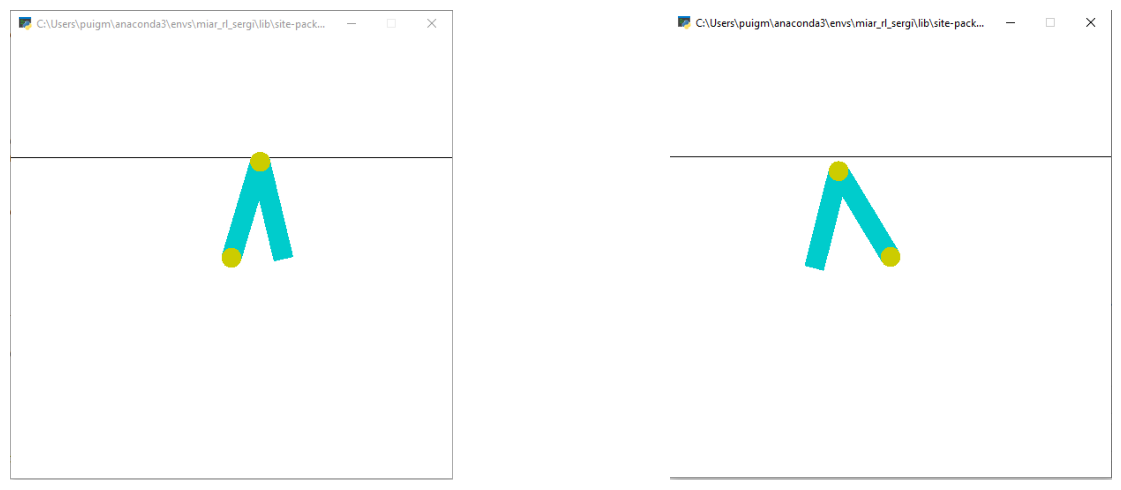

In [25]:
imagenes = ["acrobot1.png", "acrobot2.png"]

fig, axs = plt.subplots(1, len(imagenes), figsize=(15, 5))

for ax, img_path in zip(axs, imagenes):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off') 

plt.tight_layout()
plt.show()

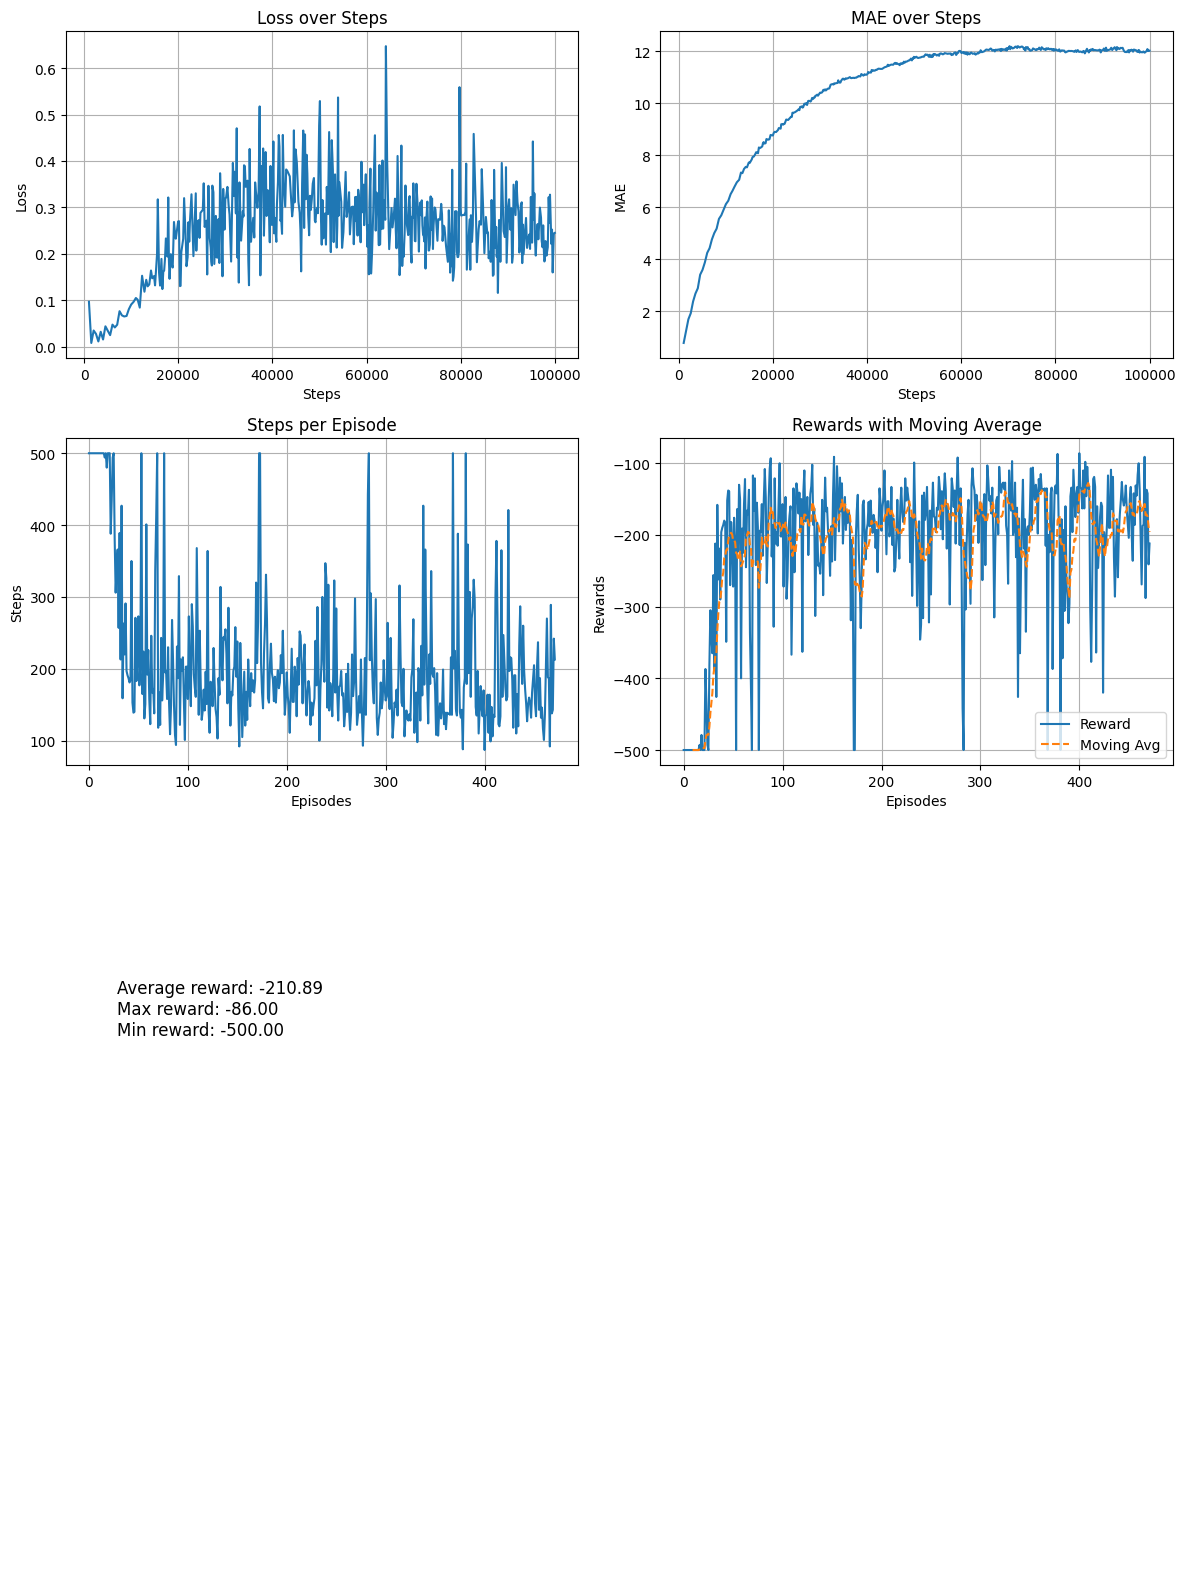

In [30]:
visualizar_log(log_filename)

Como podemos observar, el rendimiento de Double DQN es ligeramente peor al de Epsilon Greedy DQN. La recompensa media de Double DQN es -120.65 mientras que la de greedy DQN ha salido de -199.79

Una posible explicación a esta diferencia podría ser que double DQN introduce un modelo adicional que require una mayor cantidad de evaluaciones de hiperparámetros para encontrar configuraciones óptimas. Por limitaciones computacionales no se han podido explorar tantas combinaciones de parámetros como en Greedy DQN. Además sospechamos que Double DQN puede ser más conservador para actualizar los valores de Q debido a su mecanismo de la doble red para mitigar el sobreestimado. Esto podría haber favorecido un retraso en el aprendizaje.

#### Dueling DQN

### Configuración y Arquitectura del Modelo Dueling DQN

Para garantizar una comparación justa y precisa del rendimiento del agente **Dueling DQN**, se utilizó una red neuronal con una arquitectura consistente y bien definida. Esta red consta de las siguientes características:

- **Red Neuronal Base:**
  - Una red compartida con **dos capas densas (fully connected)** de tamaños **256** y **256** neuronas respectivamente, utilizando la activación **ReLU** para capturar representaciones no lineales del entorno.
  - La separación de la red en dos **streams**:
    - **Stream de Ventaja (Advantage)**: Incluye dos capas adicionales de **128** y **64** neuronas con activación **ReLU**, y una salida con dimensiones iguales al número de acciones posibles (`nb_actions`).
    - **Stream de Valor (Value)**: Cuenta con dos capas densas adicionales de **128** y **64** neuronas con activación **ReLU**, y una salida escalar para estimar el valor del estado actual.

La combinación de ambos streams permite al modelo calcular los valores Q utilizando la siguiente fórmula:
$$
Q(s, a) = V(s) + A(s, a) - \frac{1}{|A|} \sum_{a'} A(s, a'),
$$
donde:
-  $V(s)$: Es el valor del estado actual.
- $ A(s, a) $: Representa la ventaja de cada acción.
- $ |A| $: Es el número total de acciones disponibles.

---

### Configuración del Entrenamiento
El agente **Dueling DQN** fue configurado con los siguientes hiperparámetros, que optimizan su rendimiento en el entorno:

- **Ventana de observación (`window_length`)**: 4 pasos consecutivos del entorno.
- **Tasa de descuento ($\gamma $)**: 0.99, para priorizar recompensas a largo plazo.
- **Política de exploración**:
  - **Linear Annealed Epsilon Greedy**: Reduce el valor de epsilon ($\epsilon$) de 1.0 a 0.05 durante **100,000** pasos, permitiendo una transición suave entre exploración y explotación.
- **Memoria de Repetición de Experiencias**:
  - **Capacidad**: 200,000 experiencias.
  - **Batch Size**: 64 muestras por actualización.
- **Actualización de la Red Objetivo**:
  - La red objetivo se actualiza cada **500 pasos**, copiando los pesos de la red principal.
- **Optimización**:
  - Se utilizó el optimizador **Adam** con una tasa de aprendizaje de $1e-4$.
  - **Precisión mixta** habilitada mediante **mixed_float16** para mejorar el rendimiento computacional.

---

### Implementación del Agente
El agente fue implementado utilizando **Keras-RL** con la funcionalidad del **Dueling DQN** habilitada. La configuración asegura que las actualizaciones se realicen de manera eficiente y que la lógica de **ventaja** y **valor** se integre automáticamente en la arquitectura. Adicionalmente, se estableció un intervalo de calentamiento (`nb_steps_warmup`) de **1,000 pasos** iniciales para llenar la memoria de repetición antes de iniciar el entrenamiento.

Esta configuración robusta y eficiente permite al **Dueling DQN** aprovechar su arquitectura superior para mejorar la estabilidad y precisión de las estimaciones de Q-Values, reduciendo significativamente problemas como la **sobreestimación** de acciones observados en métodos tradicionales como **DQN**.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
import tensorflow as tf
import gym
import os
import matplotlib.pyplot as plt


2024-12-15 17:26:22.268869: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
# Configuración enviroment
env_name = 'Acrobot-v1'
env = gym.make(env_name)

# Semillas de reproducibilidad
np.random.seed(123)
env.seed(123)

# Set observations and actions spaces
n_obs = env.observation_space
nb_actions = env.action_space.n

In [ ]:
# Implementación de la red con arquitectura Dueling DQN
def build_dueling_model_improved(window_length, input_shape, nb_actions):
    input_layer = tf.keras.layers.Input(shape=(window_length,) + input_shape)
    flatten = tf.keras.layers.Flatten()(input_layer)

    # Red compartida
    shared_dense = tf.keras.layers.Dense(256, activation='relu')(flatten)
    shared_dense = tf.keras.layers.Dense(256, activation='relu')(shared_dense)

    # Stream de ventaja
    advantage_fc = tf.keras.layers.Dense(128, activation='relu')(shared_dense)
    advantage_fc = tf.keras.layers.Dense(64, activation='relu')(advantage_fc)
    advantage = tf.keras.layers.Dense(nb_actions, activation='linear')(advantage_fc)

    # Stream de valor
    value_fc = tf.keras.layers.Dense(128, activation='relu')(shared_dense)
    value_fc = tf.keras.layers.Dense(64, activation='relu')(value_fc)
    value = tf.keras.layers.Dense(1, activation='linear')(value_fc)

    # Cálculo Q(s, a) = V(s) + A(s, a) - promedio(A(s, a))
    output = tf.keras.layers.Add()([
        value,
        tf.keras.layers.Subtract()([
            advantage,
            tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(advantage)
        ])
    ])

    return tf.keras.models.Model(inputs=input_layer, outputs=output)


# Crear modelo mejorado
window_length = 4
input_shape = env.observation_space.shape
improved_dueling_model = build_dueling_model_improved(window_length, input_shape, nb_actions)
improved_dueling_model.summary()

# Configurar optimización de precisión mixta
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Crear agente mejorado
dueling_dqn_improved = DQNAgent(
    model=improved_dueling_model,
    nb_actions=nb_actions,
    memory=SequentialMemory(limit=200000, window_length=window_length),
    policy=LinearAnnealedPolicy(
        EpsGreedyQPolicy(),
        attr='eps',
        value_max=1.0,
        value_min=0.05,
        value_test=0.01,
        nb_steps=100000
    ),
    nb_steps_warmup=1000,
    gamma=0.99,
    target_model_update=500,
    train_interval=8,
    batch_size=64
)
dueling_dqn_improved.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])

# Entrenar el modelo mejorado
nb_steps = 150000
dueling_history_improved = dueling_dqn_improved.fit(env, nb_steps=nb_steps, visualize=False, verbose=2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 6)]       0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 24)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          6400        flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
______________________________________________________________________________________________

2024-12-15 17:26:23.435119: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-12-15 17:26:23.451655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-15 17:26:23.453799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.807GHz coreCount: 28 deviceMemorySize: 11.66GiB deviceMemoryBandwidth: 335.32GiB/s
2024-12-15 17:26:23.453818: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-15 17:26:23.477277: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-12-15 17:26:23.477333: I tensorflow/stream_executor/pl

Training for 150000 steps ...


/home/juan/.pyenv/versions/3.8.16/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    500/150000: episode: 1, duration: 0.369s, episode steps: 500, steps per second: 1357, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.006 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1000/150000: episode: 2, duration: 0.316s, episode steps: 500, steps per second: 1584, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.040 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/home/juan/.pyenv/versions/3.8.16/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   1500/150000: episode: 3, duration: 1.290s, episode steps: 500, steps per second: 388, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.052 [0.000, 2.000],  loss: 0.083347, mae: 0.664307, mean_q: -0.796135, mean_eps: 0.988106
   2000/150000: episode: 4, duration: 0.801s, episode steps: 500, steps per second: 624, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.044 [0.000, 2.000],  loss: 0.068736, mae: 1.295230, mean_q: -1.771068, mean_eps: 0.983394
   2500/150000: episode: 5, duration: 0.761s, episode steps: 500, steps per second: 657, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.080 [0.000, 2.000],  loss: 0.067315, mae: 1.988835, mean_q: -2.806232, mean_eps: 0.978644
   3000/150000: episode: 6, duration: 0.762s, episode steps: 500, steps per second: 656, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.956 [0.000, 2.000],  loss: 0.069266, mae: 2.600748, mean_q

In [ ]:
# Crear directorio para guardar resultados
output_dir = f"results_{env_name}_juan"
os.makedirs(output_dir, exist_ok=True)

# Guardar modelo completo y pesos
dueling_dqn_improved.model.save(os.path.join(output_dir, f'dueling_dqn_{env_name}_improved_model.h5'))
dueling_dqn_improved.save_weights(os.path.join(output_dir, f'dueling_dqn_{env_name}_improved_weights.h5f'), overwrite=True)

# Exportar logs de entrenamiento a CSV
train_history_df = pd.DataFrame(dueling_history_improved.history)
train_history_df.to_csv(os.path.join(output_dir, f'dueling_dqn_{env_name}_improved_train_log.csv'), index=False)

# Evaluar el modelo mejorado
dueling_test_improved = dueling_dqn_improved.test(env, nb_episodes=10, visualize=False)
test_rewards = dueling_test_improved.history['episode_reward']

# Guardar recompensas de prueba

np.savetxt(os.path.join(output_dir, f'dueling_dqn_{env_name}_improved_test_rewards.csv'), test_rewards, delimiter=',')

Testing for 10 episodes ...
Episode 1: reward: -74.000, steps: 75
Episode 2: reward: -74.000, steps: 75
Episode 3: reward: -103.000, steps: 104
Episode 4: reward: -70.000, steps: 71
Episode 5: reward: -69.000, steps: 70
Episode 6: reward: -118.000, steps: 119
Episode 7: reward: -69.000, steps: 70
Episode 8: reward: -74.000, steps: 75
Episode 9: reward: -74.000, steps: 75
Episode 10: reward: -86.000, steps: 87


In [34]:
# Recompensa media durante la evaluación
evaluation_rewards = dueling_test_improved.history['episode_reward']
mean_evaluation_reward = np.mean(evaluation_rewards)

print(f"Recompensa media durante la evaluación: {mean_evaluation_reward:.2f}")


Recompensa media durante la evaluación: -81.10


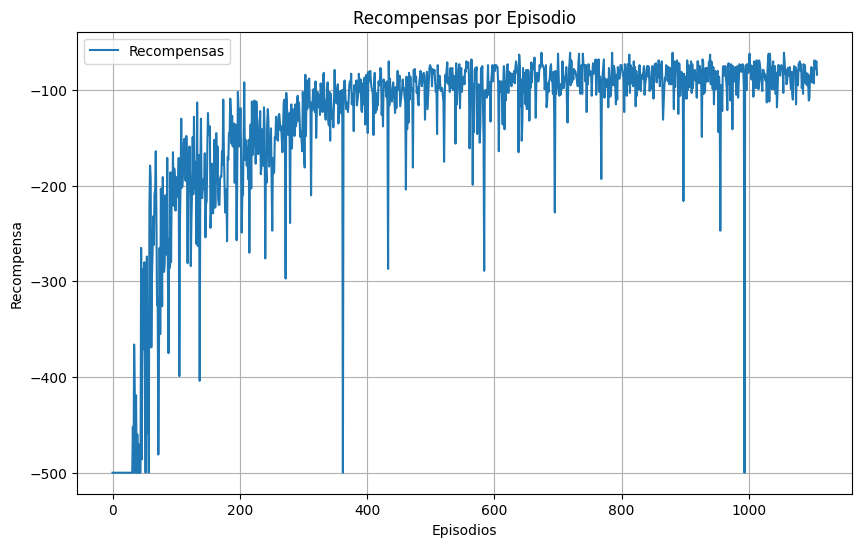

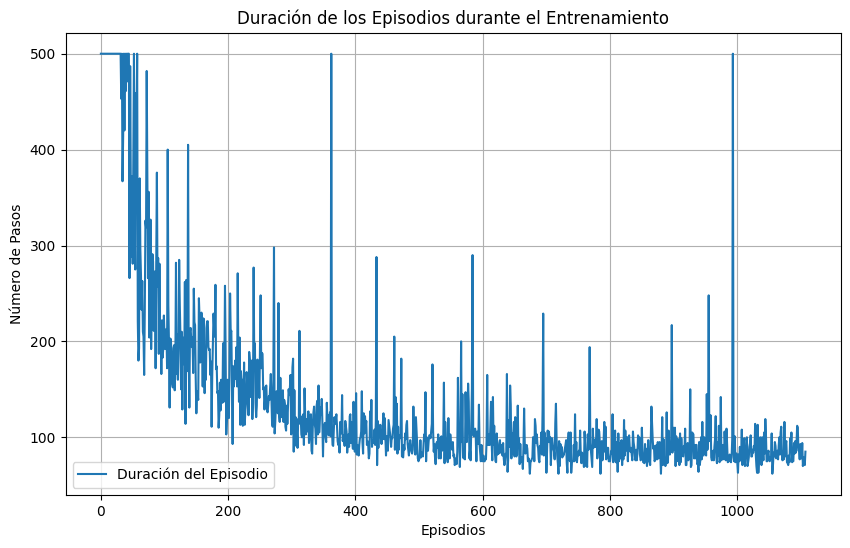

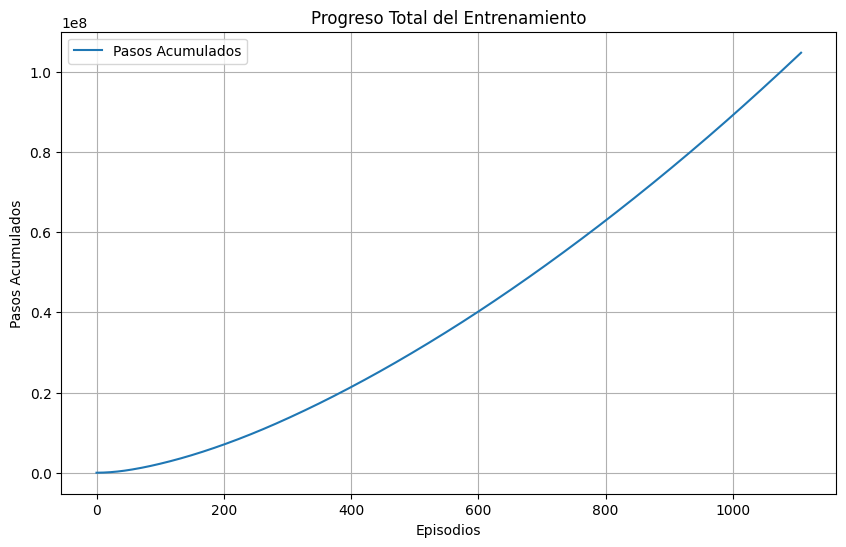

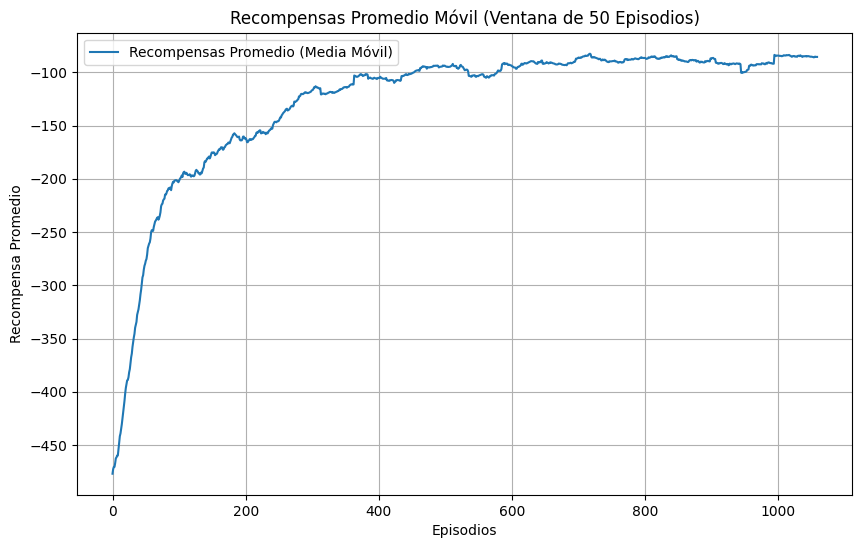

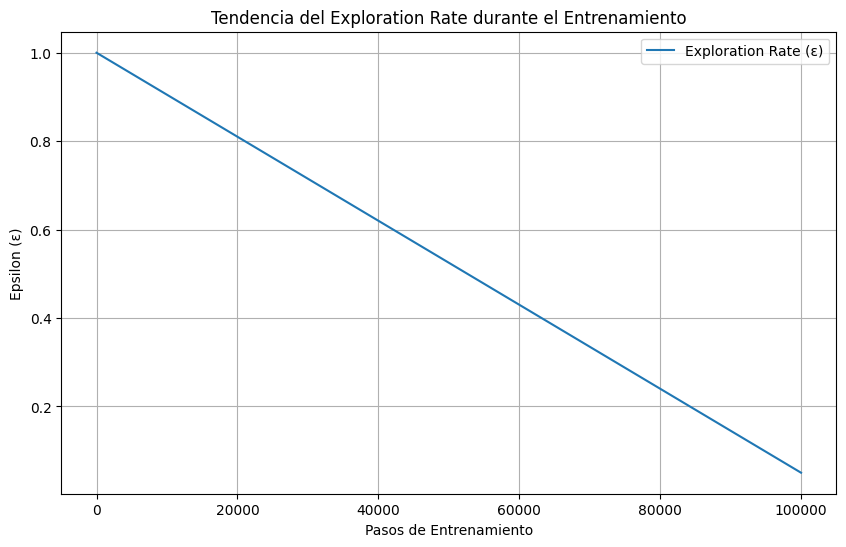

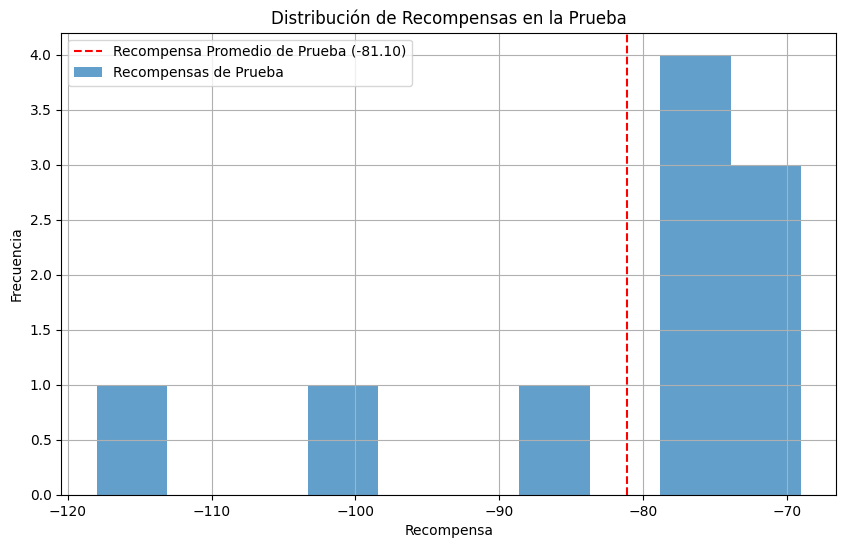

In [15]:
# Graficar recompensas por episodio
plt.figure(figsize=(10, 6))
plt.plot(range(len(dueling_history_improved.history['episode_reward'])), dueling_history_improved.history['episode_reward'], label='Recompensas')
plt.xlabel('Episodios')
plt.ylabel('Recompensa')
plt.title('Recompensas por Episodio')
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_dir, 'reward_per_episode_improved.png'))
plt.show()

# Graficar la duración de los episodios (número de pasos por episodio)
plt.figure(figsize=(10, 6))
plt.plot(range(len(dueling_history_improved.history['nb_episode_steps'])), 
         dueling_history_improved.history['nb_episode_steps'], label='Duración del Episodio')
plt.xlabel('Episodios')
plt.ylabel('Número de Pasos')
plt.title('Duración de los Episodios durante el Entrenamiento')
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_dir, 'episode_duration_improved.png'))
plt.show()

# Graficar el progreso total en el entorno (pasos acumulados)
total_steps = np.cumsum(dueling_history_improved.history['nb_steps'])
plt.figure(figsize=(10, 6))
plt.plot(range(len(total_steps)), total_steps, label='Pasos Acumulados')
plt.xlabel('Episodios')
plt.ylabel('Pasos Acumulados')
plt.title('Progreso Total del Entrenamiento')
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_dir, 'total_steps_improved.png'))
plt.show()


window_size = 50  # Tamaño de la ventana para la media móvil
smoothed_rewards = np.convolve(
    dueling_history_improved.history['episode_reward'], 
    np.ones(window_size)/window_size, 
    mode='valid'
)

# Graficar recompensas promedio móviles
plt.figure(figsize=(10, 6))
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label='Recompensas Promedio (Media Móvil)')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.title(f'Recompensas Promedio Móvil (Ventana de {window_size} Episodios)')
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_dir, 'smoothed_rewards_improved.png'))
plt.show()

# Generar valores de epsilon para los pasos de entrenamiento
eps_values = np.linspace(1.0, 0.05, 100000)  # Usar parámetros de LinearAnnealedPolicy

# Graficar epsilon vs pasos
plt.figure(figsize=(10, 6))
plt.plot(range(len(eps_values)), eps_values, label='Exploration Rate (ε)')
plt.xlabel('Pasos de Entrenamiento')
plt.ylabel('Epsilon (ε)')
plt.title('Tendencia del Exploration Rate durante el Entrenamiento')
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_dir, 'epsilon_decay_improved.png'))
plt.show()


avg_test_reward = np.mean(test_rewards)

# Graficar comparación de recompensas
plt.figure(figsize=(10, 6))
plt.hist(test_rewards, bins=10, alpha=0.7, label='Recompensas de Prueba')
plt.axvline(avg_test_reward, color='red', linestyle='--', label=f'Recompensa Promedio de Prueba ({avg_test_reward:.2f})')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
plt.title('Distribución de Recompensas en la Prueba')
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_dir, 'test_reward_distribution_improved.png'))
plt.show()




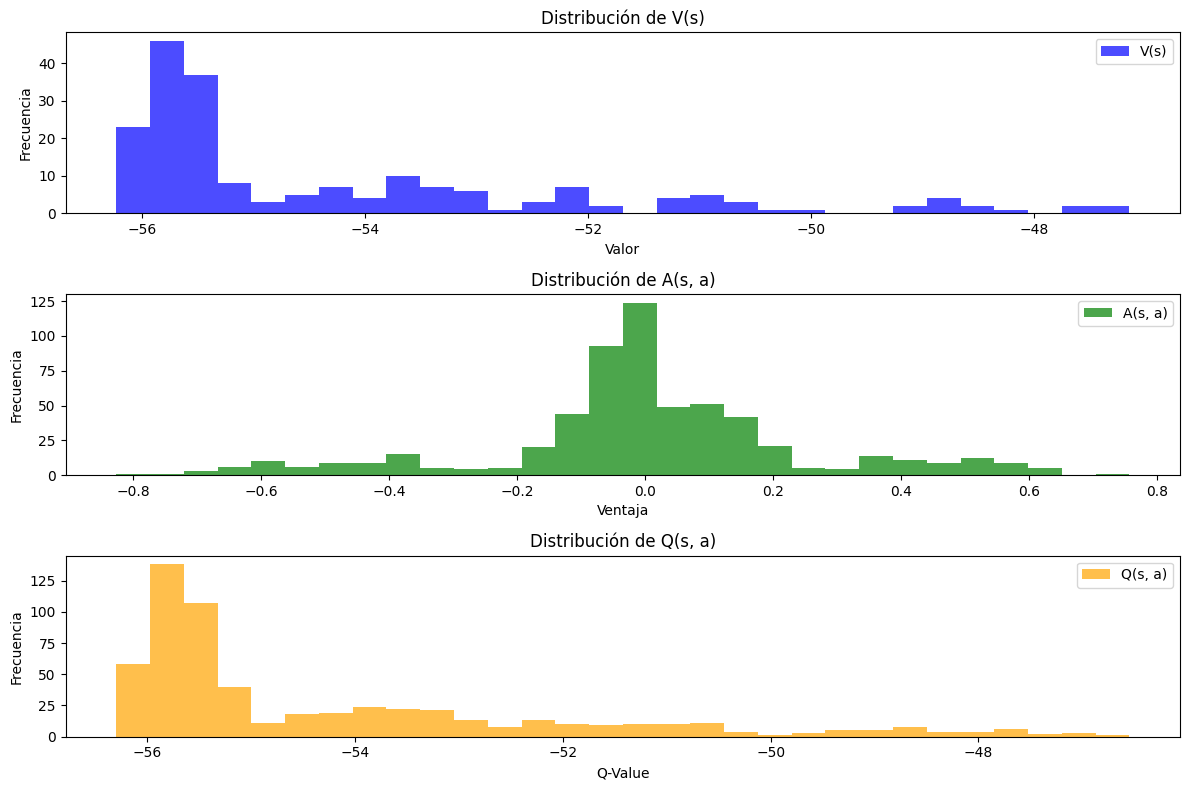

In [30]:
# Crear ventanas deslizantes para las muestras
window_length = 4
def create_sliding_window(states, window_length):
    windows = []
    for i in range(len(states) - window_length + 1):
        windows.append(states[i:i + window_length])
    return np.array(windows)

# Generar muestras del entorno
sample_states = []
for _ in range(100):  # Tomar 100 estados de muestra
    state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Acción aleatoria
        next_state, _, done, _ = env.step(action)
        sample_states.append(state)
        state = next_state
        if len(sample_states) >= 100:
            break

# Ajustar las muestras al formato esperado
sample_states_sliding = create_sliding_window(np.array(sample_states), window_length)

# Extraer valores de V(s), A(s, a) y Q(s, a)
values = value_model.predict(sample_states_sliding)
advantages = advantage_model.predict(sample_states_sliding)
q_values = values + (advantages - np.mean(advantages, axis=1, keepdims=True))

# Graficar histogramas
plt.figure(figsize=(12, 8))

# Valores (V)
plt.subplot(3, 1, 1)
plt.hist(values, bins=30, alpha=0.7, color='blue', label='V(s)')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Distribución de V(s)')
plt.legend()

# Ventajas (A)
plt.subplot(3, 1, 2)
plt.hist(advantages.flatten(), bins=30, alpha=0.7, color='green', label='A(s, a)')
plt.xlabel('Ventaja')
plt.ylabel('Frecuencia')
plt.title('Distribución de A(s, a)')
plt.legend()

# Q-Values
plt.subplot(3, 1, 3)
plt.hist(q_values.flatten(), bins=30, alpha=0.7, color='orange', label='Q(s, a)')
plt.xlabel('Q-Value')
plt.ylabel('Frecuencia')
plt.title('Distribución de Q(s, a)')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'q_values_distribution.png'))
plt.show()


#### Comparación del Dueling DQN con Double DQN y Epsilon Greedy DQN

Como se puede observar, el rendimiento del Dueling DQN es notablemente superior al de Double DQN y Epsilon Greedy DQN en términos de recompensa media. El Dueling DQN alcanzó una recompensa media de -81.10, mientras que Double DQN registró -120.65 y Epsilon Greedy DQN -199.79. Esta mejora sustancial indica que la arquitectura Dueling es más efectiva al descomponer las estimaciones de los Q-Values en componentes de valor y ventaja.

Al analizar la gráfica de recompensas, se aprecia que el Dueling DQN presenta una mayor estabilidad en las recompensas a lo largo de los episodios. Aunque existen algunos picos negativos ocasionales, la tendencia general muestra recompensas más consistentes y cercanas a valores óptimos. En contraste, Double DQN y Epsilon Greedy DQN tienden a exhibir mayores oscilaciones y recompensas más bajas en promedio.

La ventaja clave del Dueling DQN reside en su capacidad para evaluar con precisión el valor de los estados y la ventaja de las acciones, lo que permite al modelo discriminar de manera más efectiva entre acciones con valores similares. Esto reduce la influencia de las acciones con estimaciones sobrevaloradas, una debilidad común en modelos como el Epsilon Greedy DQN.

Por otro lado, aunque Double DQN mejora sobre Epsilon Greedy DQN al reducir el sobreoptimismo en las estimaciones de Q-Values, su desempeño sigue siendo inferior al Dueling DQN, debido a que no implementa la separación entre valor y ventaja en el cálculo de los Q-Values. Esta característica específica del Dueling DQN parece ser determinante para lograr recompensas más estables y un aprendizaje más eficiente.

En conclusión, el Dueling DQN demuestra ser un modelo más robusto y estable, lo que lo convierte en una opción superior para entornos donde las recompensas son ruidosas y el agente necesita diferenciar con mayor precisión entre acciones óptimas y subóptimas.

---
### 4. Exploración de hyper-parámetros. Discusión de los resultados.

#### Double DQN -  hiperparámetros:

Como se explicó en el apartado 3, para la configuración del modelo Double DQN, se utilizó la optimización bayesiana a través de Optuna para seleccionar los hiperparámetros más adecuados, con el objetivo de maximizar la recompensa media obtenida en los episodios de prueba. A continuación, detallamos los hiperparámetros clave que hemos usado en el modelo y su justificación.

##### 1. Tasa de Aprendizaje (Learning Rate)
- Valor seleccionado: `0.0001646`
  
La tasa de aprendizaje es uno de los hiperparámetros más críticos, ya que determina la rapidez con que el modelo se ajusta a los gradientes. Un valor muy alto puede llevar a una convergencia inestable, mientras que un valor bajo puede ralentizar el aprendizaje. El valor seleccionado fue un compromiso entre la velocidad de aprendizaje y la estabilidad del modelo, lo que permitió al agente aprender de manera eficiente sin que el modelo se volviera inestable.

##### 2. Tamaño de Lote (Batch Size)
- Valor seleccionado: `64`
  
El tamaño de lote nos determina cuántos ejemplos de entrenamiento se usan para calcular el gradiente en cada actualización. Un tamaño de lote más grande proporciona estimaciones más estables del gradiente, pero aumenta el tiempo de entrenamiento, mientras que un tamaño más pequeño acelera el proceso pero aumenta la variabilidad en el aprendizaje. El valor de `64` fue elegido por su balance entre velocidad de entrenamiento y estabilidad, lo que mejoró el rendimiento general del agente. Al no ser un problema exagerademente exigente en cuanto tiempo de obtener resultados poco prometedores podemos disminuir este valor a 32 o incluso 16

##### 3. Factor de Descuento (Gamma)
- Valor seleccionado: `0.9509`
  
El parámetro `gamma` nos ayuda a controlar la importancia de las recompensas futuras frente a las recompensas inmediatas. Un valor cercano a 1 implica que el agente valora más las recompensas a largo plazo. El valor optimizado de `0.9509` proporciona un buen equilibrio entre las recompensas inmediatas y las futuras, permitiendo que el agente aprenda de manera efectiva sin perder demasiado enfoque en las recompensas inmediatas.

##### 4. Épsilon Máximo y Mínimo (Max EPS, Min EPS)
- Valores seleccionados: `max_eps = 0.9478`, `min_eps = 0.0598`
  
Estos valores controlan la política de exploración del agente. El parámetro `max_eps` determina la tasa de exploración inicial, mientras que `min_eps` define el valor mínimo al que puede llegar el epsilon. Un valor mayor de `max_eps` permite una mayor exploración en los primeros pasos, mientras que el valor de `min_eps` asegura que el agente haga una explotación suficiente de sus conocimientos aprendidos. Los valores seleccionados permiten una transición suave de exploración a explotación durante el entrenamiento.

##### 5. Pasos de Exploración (Steps Exploration)
- Valor seleccionado: `25329`
  
Este parámetro nos define cuántos pasos de exploración realiza el agente antes de comenzar a explotar su política aprendida. Un mayor número de pasos de exploración ayudará a nuestro agente a aprender más sobre el entorno antes de centrarse en explotar su conocimiento. El valor de `25329` fue seleccionado para asegurar una exploración suficiente y evitar el sobreajuste.

##### 6. Actualización de la Red Objetivo (Target Model Update)
- Valor seleccionado: `800`
  
Este parámetro regula con qué frecuencia se actualiza la red objetivo en Double DQN. Un valor más bajo podría hacer que la red objetivo se actualice demasiado rápido, lo que podría generar inestabilidad, mientras que un valor más alto podría ralentizar el proceso de aprendizaje. El valor seleccionado de `800` mantiene un buen equilibrio, actualizando la red objetivo con la frecuencia necesaria para mantener la estabilidad sin reducir demasiado la velocidad de aprendizaje.

##### 7. Filtros en la Capa Convolucional (Filters Layer 1 y Layer 2)
- Valores seleccionados: `filters_layer1 = 128`, `filters_layer2 = 64`
  
Los filtros en las capas convolucionales permiten que la red extraiga características de las observaciones del entorno. Un mayor número de filtros mejora la capacidad de la red para detectar características complejas, pero también incrementa la carga computacional. Los valores seleccionados fueron elegidos para proporcionar suficiente capacidad de extracción de características sin sobrecargar el modelo.

A pesar de que el número de neuronas por capa se obtuvo mediante Optuna, la configuración de la arquitectura es idéntica a la greedy DQN por lo que la comparación entre ambos modelos es lo más realista posibls (pues ambos han trabajado en las mismas condiciones) 

##### Impacto en el Rendimiento

Los hiperparámetros seleccionados resultaron en una mejora significativa en la recompensa media y en la estabilidad del modelo. En particular, los valores de `max_eps` y `min_eps` ayudaron a mantener una política de exploración efectiva, permitiendo que el agente explorara adecuadamente al inicio y luego explotara su conocimiento aprendido. La frecuencia de actualización de la red objetivo (`target_model_update = 800`) contribuyó a un entrenamiento más estable, evitando fluctuaciones abruptas en las recompensas.

El cambio en el `gamma` (0.95) permitió un buen balance entre recompensas a corto y largo plazo, mientras que la tasa de aprendizaje de `0.0001646` contribuyó a un ajuste efectivo de los pesos sin generar inestabilidad.

Podemos visualizar el impacto de cada uno de los hiperparámetros si lo comparamos con la recompensa media mediante una matriz de correlación:

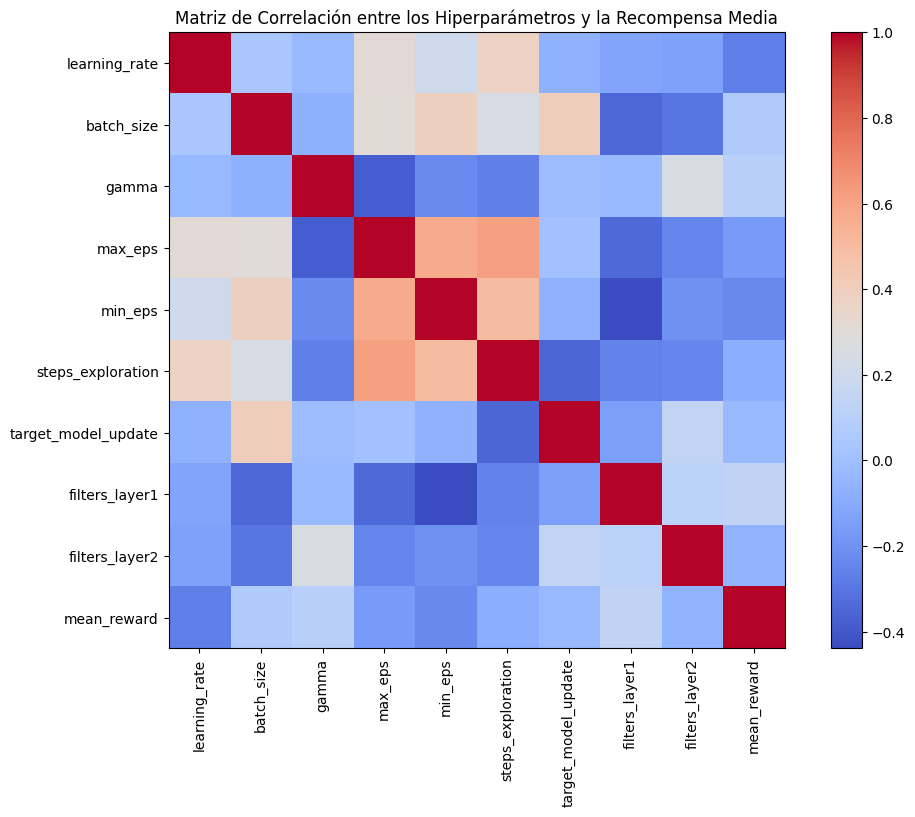

In [65]:
correlation_matrix = df[['learning_rate', 'batch_size', 'gamma', 'max_eps', 'min_eps', 
                         'steps_exploration', 'target_model_update', 'filters_layer1', 
                         'filters_layer2', 'mean_reward']].corr()

plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Matriz de Correlación entre los Hiperparámetros y la Recompensa Media')
plt.show()

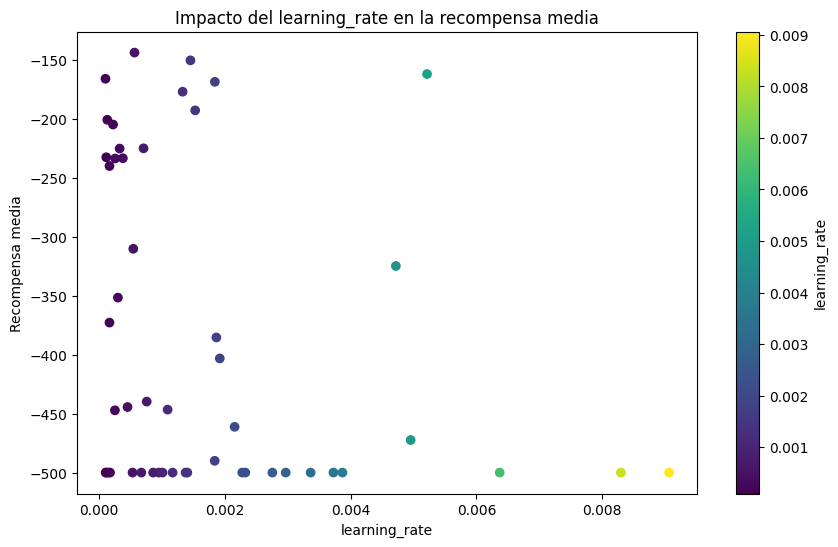

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(df['learning_rate'], df['mean_reward'], c=df['learning_rate'], cmap='viridis')
plt.colorbar(label='learning_rate')
plt.title('Impacto del learning_rate en la recompensa media')
plt.xlabel('learning_rate')
plt.ylabel('Recompensa media')
plt.show()

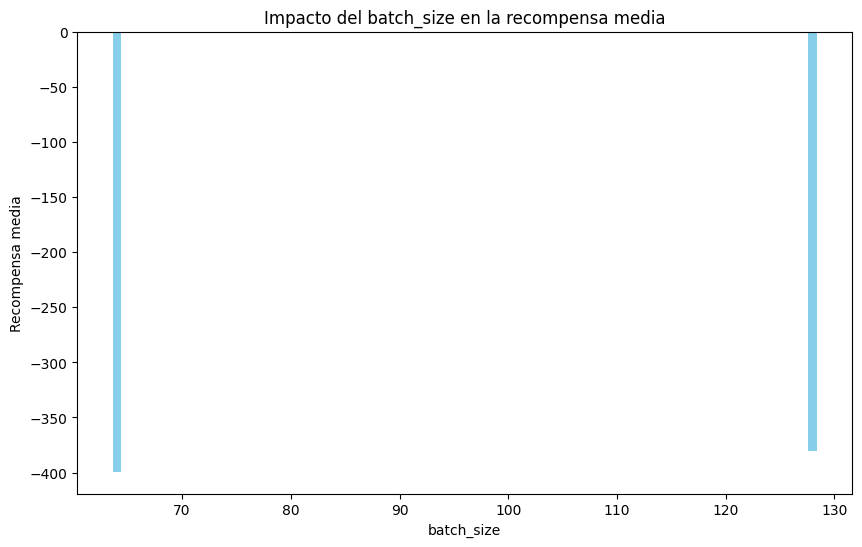

In [62]:
plt.figure(figsize=(10, 6))
df_batch = df.groupby('batch_size')['mean_reward'].mean()
plt.bar(df_batch.index, df_batch.values, color='skyblue')
plt.title('Impacto del batch_size en la recompensa media')
plt.xlabel('batch_size')
plt.ylabel('Recompensa media')
plt.show()

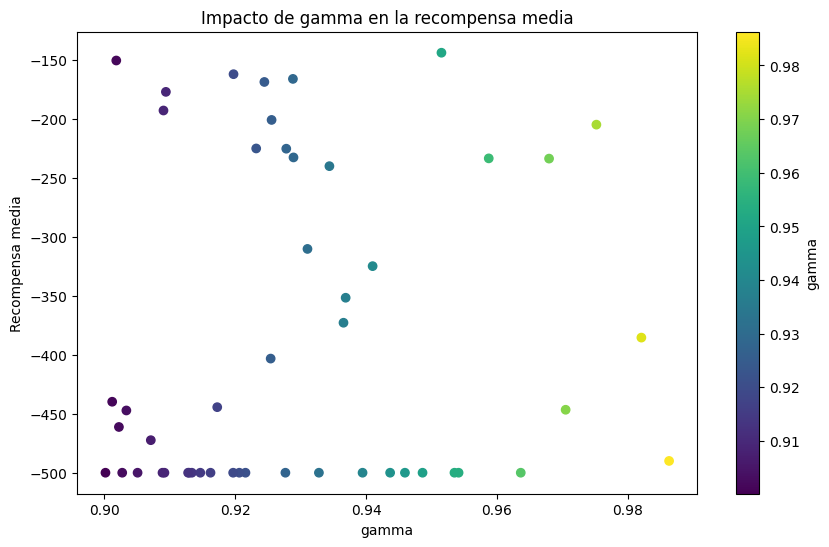

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(df['gamma'], df['mean_reward'], c=df['gamma'], cmap='viridis')
plt.colorbar(label='gamma')
plt.title('Impacto de gamma en la recompensa media')
plt.xlabel('gamma')
plt.ylabel('Recompensa media')
plt.show()

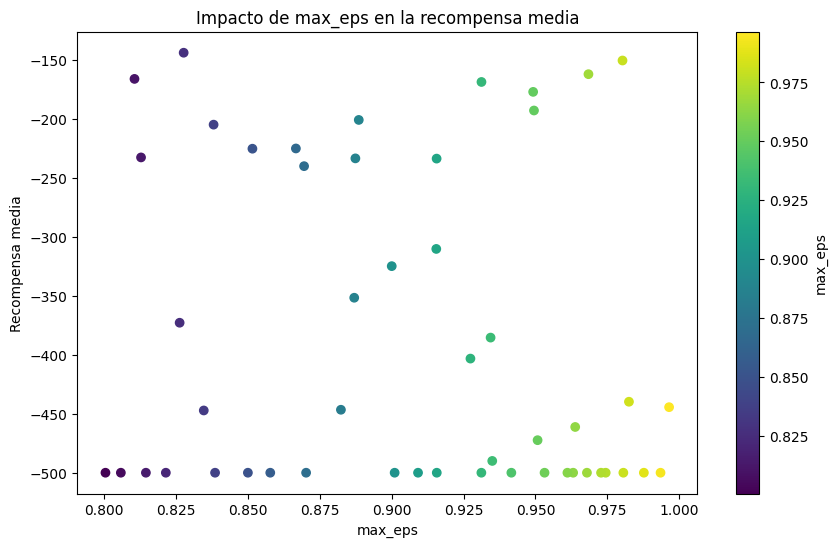

In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(df['max_eps'], df['mean_reward'], c=df['max_eps'], cmap='viridis')
plt.colorbar(label='max_eps')
plt.title('Impacto de max_eps en la recompensa media')
plt.xlabel('max_eps')
plt.ylabel('Recompensa media')
plt.show()

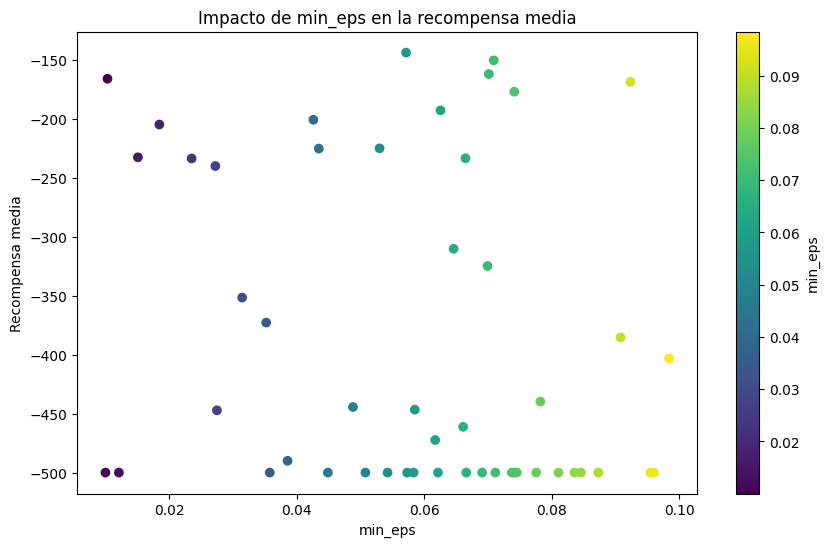

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(df['min_eps'], df['mean_reward'], c=df['min_eps'], cmap='viridis')
plt.colorbar(label='min_eps')
plt.title('Impacto de min_eps en la recompensa media')
plt.xlabel('min_eps')
plt.ylabel('Recompensa media')
plt.show()

---
### 5. Conclusiones y discusión

En este trabajo, se ha centrado el análisis en el uso de EEGreedy DQN, optimizado mediante Optuna para la selección de hiperparámetros. Este método implementa una política de exploración-explotación mediante la variable epsilon, que equilibra la exploración de nuevas acciones con la explotación de las ya conocidas. Además, se ha realizado un estudio de correlación de las variables numéricas, lo que nos ha permitido identificar qué hiperparámetros influyen en la recompensa final de nuestro agente.

Por otro lado, se introdujo Double DQN donde se utiliza un modelo objetivo adicional para la selección de acciones, lo que permite mitigar el sobreajuste y la sobreestimación de las Q-values que pueden ocurrir en el EEGreedy DQN tradicional. Al igual que en EEGreedy DQN, se optó por optimizar los hiperparámetros de Double DQN mediante Optuna, lo que permitió una búsqueda eficiente del mejor conjunto de parámetros.